<a href="https://colab.research.google.com/github/Sonkevin8/CS302-SnapCal/blob/main/SnapCalMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#MAIN

import os
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data
from collections import deque
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.io import decode_image
from tqdm.notebook import tqdm
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader, default_collate, Dataset, random_split
import torch.optim as optim
import timm
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
import h5py
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
import cv2
from tqdm import tqdm

from google.colab import auth, drive

auth.authenticate_user()
drive.mount('/content/drive', force_remount= True)

img_folder = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/images/"
csv_file = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/labels.csv"

print('Pytorch version: ', torch.__version__)
print('Pandas Version: ' , pd.__version__)
print('Numpy Version: ' , np.__version__)
print('Timm Version: ' , timm.__version__)

df = pd.read_csv(csv_file)
print(df.head())
print(df.columns)

os.listdir('/content')

Mounted at /content/drive
Pytorch version:  2.8.0+cu126
Pandas Version:  2.2.2
Numpy Version:  2.0.2
Timm Version:  1.0.22
   id  original_dish_id   calories
0 NaN        1556572657  41.399998
1 NaN        1556573514   6.440000
2 NaN        1556575014  71.299995
3 NaN        1556575083  27.520000
4 NaN        1556575124   4.480000
Index(['id', 'original_dish_id', 'calories'], dtype='object')


['.config', 'drive', 'sample_data']

In [ ]:
#Initialize Front end with port and link

# Stop any potentially lingering streamlit processes more aggressively
!kill -9 $(lsof -i :8501 -t) >/dev/null 2>&1 || true
!kill -9 $(lsof -i :8502 -t) >/dev/null 2>&1 || true
!pkill -f streamlit
print("Attempted to kill all streamlit processes.")

# Add a small delay to ensure processes are stopped
import time
time.sleep(7) # Increased sleep time

# Install necessary libraries before running the app
!pip install pyngrok streamlit opencv-python

# Add another delay after installation
time.sleep(10)


# Restart the streamlit app on a new port
!streamlit run app.py --server.port 8503 > streamlit.log 2>&1 &

from pyngrok import ngrok
import os
from google.colab import userdata
import time

# Get your authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
if NGROK_AUTH_TOKEN is None:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
else:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    print("Waiting for Streamlit app to start...")
    # Increased delay to give Streamlit more time to start and ngrok to connect
    time.sleep(15)

    try:
        # Kill existing ngrok tunnels before connecting
        ngrok.kill()
        print("Killed existing ngrok tunnels before starting a new one.")
        # Connect to the new port 8503
        public_url = ngrok.connect(8503)
        print(f"Streamlit app URL: {public_url}")
    except Exception as e:
        print(f"Error connecting ngrok: {e}")
        print("Please check if Streamlit is running and accessible on port 8503.")

Attempted to kill all streamlit processes.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.9 MB/s eta 0:00:00


In [ ]:
# =====================================
# === Image loader with fallback=======
# =====================================

def safe_open(img_dir, dish_id, suffix, mode):
    for ext in ['.png', '.PNG', '.jpg', '.JPG']:
        path = os.path.join(img_dir, f"{dish_id}_{suffix}{ext}")
        if os.path.exists(path):
            try:
                img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                if img is None or img.size == 0:
                    print(f"Skipping unreadable {suffix} image: {path}")
                    return Image.new(mode, (448, 448))
                if img.dtype != np.uint8:
                    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
                if len(img.shape) == 2:
                    pil_img = Image.fromarray(img).convert(mode)
                else:
                    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).convert(mode)
                return pil_img
            except Exception as e:
                print(f"Skipping corrupted {suffix} image: {path} ({e})")
                return Image.new(mode, (448, 448))
    # file not found
    print(f" Missing file for {dish_id}_{suffix}")
    return Image.new(mode, (448, 448))

In [ ]:
# ===============================
# 🧠 Model
# ===============================

class MultiInputSnapCalCNN(nn.Module):
    def __init__(self):
        super(MultiInputSnapCalCNN, self).__init__()

        # Feature extraction for RGB (3 channels)
        self.features_rgb = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Shared for Heat & Depth
        self.features_mono = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_rgb_cont = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_heat_cont = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_depth_cont = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        total_flattened_features = 256 + 128

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_flattened_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x_rgb, x_heat):
      # --- RGB branch ---
      features_rgb = self.features_rgb(x_rgb)
      features_rgb = self.features_rgb_cont(features_rgb)

      # --- Heat (grayscale) branch ---
      features_heat = self.features_mono(x_heat)
      features_heat = self.features_heat_cont(features_heat)

      # --- Global Average Pooling ---
      features_rgb = self.gap(features_rgb)
      features_heat = self.gap(features_heat)

      # --- Flatten ---
      features_rgb = features_rgb.view(features_rgb.size(0), -1)
      features_heat = features_heat.view(features_heat.size(0), -1)

      # --- Concatenate (remove depth entirely) ---
      combined = torch.cat((features_rgb, features_heat), dim=1)

      # --- Final prediction head ---
      output = self.classifier(combined)
      return output

In [ ]:
# ===============================
# 🧠 Your Model
# ===============================

class MultiInputSnapCalCNN(nn.Module):
    def __init__(self, return_features=False):
        super(MultiInputSnapCalCNN, self).__init__()

        self.return_features = return_features

        # Feature extraction for RGB (3 channels)
        self.features_rgb = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Shared for Heat & Depth
        self.features_mono = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_rgb_cont = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_heat_cont = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.features_depth_cont = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        total_flattened_features = 256 + 128

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_flattened_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x_rgb, x_heat):
        # Extract RGB features
        f_rgb = self.features_rgb(x_rgb)
        f_rgb = self.features_rgb_cont(f_rgb)
        f_rgb = self.gap(f_rgb).view(f_rgb.size(0), -1)

        # Extract gray (heat) features
        f_heat = self.features_mono(x_heat)
        f_heat = self.features_heat_cont(f_heat)
        f_heat = self.gap(f_heat).view(f_heat.size(0), -1)

        # Concatenate RGB + Gray features
        combined = torch.cat((f_rgb, f_heat), dim=1)

        # 🧩 If used for feature extraction in hybrid model
        if self.return_features:
            return combined

        # 🔮 Otherwise, produce calorie prediction directly
        return self.classifier(combined)

In [ ]:
# =========================
# === Dataset Class =======
# =========================


class MultiModalDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, labels_df, transform_rgb=None, transform_mono=None):
        self.image_dir = image_dir
        self.transform_rgb = transform_rgb
        self.transform_mono = transform_mono
        # --- Clean up IDs to match actual filenames ---
        labels_df['original_dish_id'] = (
            labels_df['original_dish_id']
            .astype(str)
            .str.replace('.0', '', regex=False)
            .str.strip()
        )

        valid_ids = sorted(set(f.split('_')[0] for f in os.listdir(img_folder)))
        labels_df = labels_df[labels_df['original_dish_id'].isin(valid_ids)].reset_index(drop=True)
        print(f"✅ Filtered to {len(labels_df)} valid samples (removed {3493 - len(labels_df)} missing ones)")

        self.image_ids = labels_df['original_dish_id'].tolist()
        self.labels = dict(zip(self.image_ids, labels_df['calories'].values))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        dish_id = self.image_ids[idx]

        # --- Use safe_open for robust image loading ---
        rgb_img = safe_open(self.image_dir, dish_id, "rgb", "RGB")
        heat_img = safe_open(self.image_dir, dish_id, "gray", "L")
      #  depth_img = safe_open(self.image_dir, dish_id, "rgbd", "L")

        # --- Apply transforms ---
        if self.transform_rgb:
            rgb_img = self.transform_rgb(rgb_img)
        if self.transform_mono:
            if isinstance(heat_img, Image.Image):
              heat_img = self.transform_mono(heat_img)
            #if isinstance(depth_img, Image.Image):
            #depth_img = self.transform_mono(depth_img)

        cal = torch.tensor(self.labels[dish_id], dtype=torch.float)

        return rgb_img, cal
          #depth_img, heat_img

In [ ]:
# =========================
# === Transforms ==========
# =========================

# RGB transforms (3 channels)
train_transform_rgb = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform_rgb = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Mono transforms (1 channel)
train_transform_mono = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform_mono = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:

import os
import pandas as pd

csv_file = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/labels.csv"
img_folder = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/images"

# --- Load CSV ---
labels_df = pd.read_csv(csv_file)
print(f"📥 Loaded {len(labels_df)} total samples")

# --- Remove corrupted / invalid entries ---
labels_df = labels_df[labels_df["original_dish_id"] != 1564159636]

# --- Filter by calorie range (0 < cal <= 800) ---
labels_df = labels_df[(labels_df["calories"] > 0) & (labels_df["calories"] <= 800)].reset_index(drop=True)
print(f"Filtered valid calorie range (0–800 kcal) | Remaining: {len(labels_df)} samples")

# --- Clean dish IDs to match image filenames ---
labels_df["original_dish_id"] = (
    labels_df["original_dish_id"]
    .astype(str)
    .str.replace(".0", "", regex=False)
    .str.strip()
)

# --- Verify RGB + Gray image existence ---
rgb_files = {f.split("_")[0] for f in os.listdir(img_folder) if "_rgb.png" in f}
gray_files = {f.split("_")[0] for f in os.listdir(img_folder) if "_gray.png" in f}

valid_ids = sorted(list(rgb_files & gray_files))
labels_df = labels_df[labels_df["original_dish_id"].isin(valid_ids)].reset_index(drop=True)

print(f"Matched {len(labels_df)} valid image pairs (RGB + Gray)")
print("Removed any IDs missing required modalities or exceeding calorie limits.")

📥 Loaded 3493 total samples
Filtered valid calorie range (0–800 kcal) | Remaining: 3197 samples
Matched 3194 valid image pairs (RGB + Gray)
Removed any IDs missing required modalities or exceeding calorie limits.


In [ ]:
import os

depth_files = [f for f in os.listdir(img_folder) if "_rgbd" in f]
print(f"🔍 Depth images ignored: {len(depth_files)} total depth files not used.")

🔍 Depth images ignored: 3493 total depth files not used.


In [ ]:
# ============================================
# ✂️ TRAIN / VAL / TEST SPLITS
# ============================================
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(labels_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 2555, Val: 319, Test: 320


In [ ]:
# ============================================
# 🧠 DATA AUGMENTATION (TensorFlow ImageDataGenerator-like)
# ============================================

train_transform_rgb = transforms.Compose([
    transforms.RandomResizedCrop(448, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05),
    transforms.RandomAffine(degrees=10, translate=(0.08, 0.08), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.12)),
    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5)
    ], p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform_rgb = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_transform_mono = transforms.Compose([
    transforms.RandomResizedCrop(448, scale=(0.85, 1.0)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.GaussianBlur(3, sigma=(0.1, 1.2)),
    transforms.RandomErasing(p=0.4, scale=(0.02, 0.12)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_test_transform_mono = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [ ]:

#fine tuning augmentations part 2


# --- RGB augmentations ---
train_transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           # flip left/right
    transforms.RandomRotation(degrees=10),            # simulate camera tilt
    transforms.ColorJitter(
        brightness=0.25, contrast=0.25,
        saturation=0.2, hue=0.05
    ),                                                # lighting variation
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # mild zoom jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Gray & Depth augmentations ---
train_transform_mono = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# --- Validation/Test (no augmentation) ---
val_test_transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform_mono = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# ============================================
# 🖼️ DATASET INITIALIZATION (Option 1)
# ============================================

train_dataset = MultiModalDataset(
    image_dir=img_folder,
    labels_df=train_df,
    transform_rgb=train_transform_rgb,
    transform_mono=train_transform_mono,
)

val_dataset = MultiModalDataset(
    image_dir=img_folder,
    labels_df=val_df,
    transform_rgb=val_test_transform_rgb,
    transform_mono=val_test_transform_mono,
)

test_dataset = MultiModalDataset(
    image_dir=img_folder,
    labels_df=test_df,
    transform_rgb=val_test_transform_rgb,
    transform_mono=val_test_transform_mono,
)

✅ Filtered to 2555 valid samples (removed 938 missing ones)
✅ Filtered to 319 valid samples (removed 3174 missing ones)
✅ Filtered to 320 valid samples (removed 3173 missing ones)


In [ ]:
# ============================================
# 🧺 DATALOADERS
# ============================================

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=0)

print(f"Dataset ready — Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset ready — Train: 2555, Val: 319, Test: 320


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# =========================
# === Setup Device =======
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# === Model, Loss, Optim ==
# =========================
model = MultiInputSnapCalCNN().to(device)
criterion = nn.MSELoss()  # regression
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # adjust LR every 5 epochs

checkpoint_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_rgb_gray_model.pt"


Using device: cuda


NameError: name 'MultiInputSnapCalCNN' is not defined

In [ ]:

# --- Resume if checkpoint exists ---
start_epoch = 0
best_val_loss = float("inf")

if os.path.exists(checkpoint_path):
    print("✅ Found existing checkpoint, loading...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
        if "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        if "epoch" in checkpoint:
            start_epoch = checkpoint["epoch"] + 1
        if "best_val_loss" in checkpoint:
            best_val_loss = checkpoint["best_val_loss"]
        print(f"Resumed from epoch {start_epoch} (best_val_loss={best_val_loss:.4f})")
    else:
        print("Loaded weights only (old-format checkpoint).")

✅ Found existing checkpoint, loading...
Resumed from epoch 15 (best_val_loss=inf)


In [ ]:
# --- Fresh Training Setup ---
start_epoch = 0
best_val_loss = float("inf")

model = MultiInputSnapCalCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.MSELoss()

checkpoint_dir = "/content/drive/MyDrive/nutrition_model_checkpoints/fresh_cnn_retrain"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_multi_input_model.pt")

print("✅ Starting fresh CNN training from scratch.")

✅ Starting fresh CNN training from scratch.


In [ ]:
import os
import pandas as pd
from PIL import Image
from PIL import UnidentifiedImageError
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
import cv2
from tqdm import tqdm


# =========================
# === Training Loop =======
# =========================
num_epochs = 25
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

best_val_loss = float("inf")
checkpoint_dir = "/content/drive/MyDrive/nutrition_model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "/content/drive/MyDrive/nutrition_model_checkpoints/best_rgb_gray_model.pt")

for epoch in range(start_epoch, num_epochs):
    # =======================
    # TRAINING PHASE
    # =======================
    model.train()
    train_loss, train_mae = [], []

    for rgb, heat, cal in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        rgb, heat, cal = rgb.to(device), heat.to(device), cal.to(device)
        optimizer.zero_grad()

        preds = model(rgb, heat).squeeze(1)
        loss = criterion(preds, cal)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        mae = torch.mean(torch.abs(preds - cal)).item()
        train_mae.append(mae)

    avg_train_loss = np.mean(train_loss)
    avg_train_mae = np.mean(train_mae)

    # =======================
    # VALIDATION PHASE
    # =======================
    model.eval()
    val_loss, val_mae = [], []
    val_preds, val_labels = [], []

    with torch.no_grad():
        for rgb, heat, cal in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            rgb, heat, cal = rgb.to(device), heat.to(device), cal.to(device)
            preds = model(rgb, heat).squeeze(1)

            loss = criterion(preds, cal)
            val_loss.append(loss.item())
            mae = torch.mean(torch.abs(preds - cal)).item()
            val_mae.append(mae)

            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(cal.cpu().numpy().flatten())

    # Aggregate metrics
    avg_val_loss = np.mean(val_loss)       # MSE
    avg_val_mae = np.mean(val_mae)

    # Convert to numpy for global metrics
    y_true = np.array(val_labels)
    y_pred = np.array(val_preds)

    # Compute base metrics
    val_mse = np.mean((y_true - y_pred) ** 2)
    val_rmse = np.sqrt(val_mse)                     # kcal
    val_mae = np.mean(np.abs(y_true - y_pred))

    epsilon = 1e-3

    valid_mask = np.abs(y_true) > 50  # ignore any meals <50 kcal
    filtered_true = y_true[valid_mask]
    filtered_pred = y_pred[valid_mask]

    if len(filtered_true) > 0:
      # Standard MAPE (safe)
      val_mape = np.mean(
        np.abs(filtered_true - filtered_pred) /
        (np.abs(filtered_true) + epsilon)
    ) * 100

    # Symmetric MAPE (more stable)
      val_smape = 100 * np.mean(
      np.abs(filtered_pred - filtered_true) /
      (np.abs(filtered_true) + np.abs(filtered_pred) + epsilon)
    )
    else:
      val_mape, val_smape = np.nan, np.nan
    # =======================
    # LOGGING & CHECKPOINT
    # =======================
    tqdm.write(
      f"Epoch [{epoch+1}/{num_epochs}] | "
      f"Train Loss (MSE): {avg_train_loss:.3f} (kcal²) | Train MAE: {avg_train_mae:.2f} kcal || "
      f"Val RMSE: {val_rmse:.2f} kcal | Val MAE: {avg_val_mae:.2f} kcal | "
      f"Val MAPE: {val_mape:.2f}% | Val sMAPE: {val_smape:.2f}%",
    )

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict()}, best_model_path)
        print(f"--> Saved Best Model at Epoch {epoch+1}")

    scheduler.step()

# ============================================
# FINAL TEST EVALUATION
# ============================================
model.eval()
test_loss, test_mae, test_preds, test_labels = [], [], [], []

with torch.no_grad():
    for rgb, heat, cal in tqdm(test_loader, desc="Final Testing"):
        rgb, heat, cal = rgb.to(device), heat.to(device), cal.to(device)
        preds = model(rgb, heat).squeeze(1)

        loss = criterion(preds, cal)
        mae = torch.mean(torch.abs(preds - cal)).item()

        test_loss.append(loss.item())
        test_mae.append(mae)
        test_preds.extend(preds.cpu().numpy().flatten())
        test_labels.extend(cal.cpu().numpy().flatten())

avg_test_loss = np.mean(test_loss)
avg_test_mae = np.mean(test_mae)
test_mape = np.mean(
    np.abs((np.array(test_labels) - np.array(test_preds)) /
           np.clip(np.array(test_labels), 1e-6, None))
) * 100

print(
    f"\n📊 Final Test Results | "
    f"MSE: {avg_test_loss:.3f} (kcal^2) | "
    f"MAE: {avg_test_mae:.2f} kcal | "
    f"MAPE: {test_mape:.2f}%"
)

Epoch 16 Validation: 100%|██████████| 41/41 [00:14<00:00,  2.81it/s]


Epoch [16/25] | Train Loss (MSE): 22680.961 (kcal²) | Train MAE: 112.33 kcal || Val RMSE: 251.90 kcal | Val MAE: 125.15 kcal | Val MAPE: 64.08% | Val sMAPE: 21.39%
--> Saved Best Model at Epoch 16


Epoch 17 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


Epoch [17/25] | Train Loss (MSE): 22684.154 (kcal²) | Train MAE: 109.39 kcal || Val RMSE: 249.08 kcal | Val MAE: 104.77 kcal | Val MAPE: 43.90% | Val sMAPE: 17.76%
--> Saved Best Model at Epoch 17


Epoch 18 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.98it/s]


Epoch [18/25] | Train Loss (MSE): 22176.123 (kcal²) | Train MAE: 108.75 kcal || Val RMSE: 246.12 kcal | Val MAE: 103.63 kcal | Val MAPE: 46.40% | Val sMAPE: 17.83%
--> Saved Best Model at Epoch 18


Epoch 19 Validation: 100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


Epoch [19/25] | Train Loss (MSE): 20547.013 (kcal²) | Train MAE: 104.89 kcal || Val RMSE: 246.74 kcal | Val MAE: 113.08 kcal | Val MAPE: 55.60% | Val sMAPE: 19.45%


Epoch 20 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


Epoch [20/25] | Train Loss (MSE): 22796.624 (kcal²) | Train MAE: 110.02 kcal || Val RMSE: 252.25 kcal | Val MAE: 105.32 kcal | Val MAPE: 37.99% | Val sMAPE: 17.71%


Epoch 21 Validation: 100%|██████████| 41/41 [00:13<00:00,  3.01it/s]


Epoch [21/25] | Train Loss (MSE): 20336.023 (kcal²) | Train MAE: 104.69 kcal || Val RMSE: 244.71 kcal | Val MAE: 105.08 kcal | Val MAPE: 49.14% | Val sMAPE: 18.07%
--> Saved Best Model at Epoch 21


Epoch 22 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


Epoch [22/25] | Train Loss (MSE): 21413.525 (kcal²) | Train MAE: 107.09 kcal || Val RMSE: 245.77 kcal | Val MAE: 101.29 kcal | Val MAPE: 42.03% | Val sMAPE: 17.47%


Epoch 23 Validation: 100%|██████████| 41/41 [00:13<00:00,  3.00it/s]


Epoch [23/25] | Train Loss (MSE): 21562.171 (kcal²) | Train MAE: 107.98 kcal || Val RMSE: 256.68 kcal | Val MAE: 106.37 kcal | Val MAPE: 36.38% | Val sMAPE: 18.10%


Epoch 24 Training:  73%|███████▎  | 239/326 [01:42<00:35,  2.48it/s]

In [ ]:
#What This Does:

# ✅ Resumes from your best-performing model.
# ✅ Uses SmoothL1Loss to balance between MAE and MSE sensitivity.
# ✅ Reduces LR to 1e-5 for fine-grained weight updates.
# ✅ Continues to track Val RMSE, MAE, MAPE, and sMAPE.
# ✅ Automatically saves new best model if validation improves.


# --- Load best checkpoint path ---
best_model_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_rgb_gray_model.pt"

# --- Reload model and optimizer ---
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Loaded best checkpoint from fine-tuning start: {best_model_path}")

# --- Use SmoothL1Loss for better robustness to outliers ---
criterion = nn.SmoothL1Loss()

# --- Lower learning rate for fine-tuning ---
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# --- Fine-tuning parameters ---
fine_tune_epochs = 10
best_val_loss = float("inf")

for epoch in range(1, fine_tune_epochs + 1):
    # ========== TRAIN ==========
    model.train()
    train_loss, train_mae = [], []

    for rgb, heat, cal in tqdm(train_loader, desc=f"Fine-tune Epoch {epoch} Training"):
        rgb, heat, cal = rgb.to(device), heat.to(device), cal.to(device)

        optimizer.zero_grad()
        preds = model(rgb, heat).squeeze(1)
        loss = criterion(preds, cal)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_mae.append(torch.mean(torch.abs(preds - cal)).item())

    avg_train_loss = np.mean(train_loss)
    avg_train_mae = np.mean(train_mae)

    # ========== VALIDATION ==========
    model.eval()
    val_loss, val_mae, val_preds, val_labels = [], [], [], []
    with torch.no_grad():
        for rgb, heat, cal in tqdm(val_loader, desc=f"Fine-tune Epoch {epoch} Validation"):
            rgb, heat, cal = rgb.to(device), heat.to(device), cal.to(device)
            preds = model(rgb, heat).squeeze(1)
            loss = criterion(preds, cal)

            val_loss.append(loss.item())
            val_mae.append(torch.mean(torch.abs(preds - cal)).item())
            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(cal.cpu().numpy().flatten())

    # --- Compute metrics ---
    y_true, y_pred = np.array(val_labels), np.array(val_preds)
    avg_val_loss = np.mean(val_loss)
    avg_val_mae = np.mean(val_mae)
    val_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    epsilon = 1e-3
    valid_mask = np.abs(y_true) > 50
    filtered_true, filtered_pred = y_true[valid_mask], y_pred[valid_mask]

    if len(filtered_true) > 0:
        val_mape = np.mean(np.abs(filtered_pred - filtered_true) / (np.abs(filtered_true) + epsilon)) * 100
        val_smape = 100 * np.mean(np.abs(filtered_pred - filtered_true) / (np.abs(filtered_true) + np.abs(filtered_pred) + epsilon))
    else:
        val_mape, val_smape = np.nan, np.nan

    # --- Log Epoch Summary ---
    tqdm.write(
        f"Fine-tune Epoch [{epoch}/{fine_tune_epochs}] | "
        f"Train Loss: {avg_train_loss:.3f} | Train MAE: {avg_train_mae:.2f} kcal || "
        f"Val RMSE: {val_rmse:.2f} kcal | Val MAE: {avg_val_mae:.2f} kcal | "
        f"Val MAPE: {val_mape:.2f}% | Val sMAPE: {val_smape:.2f}%"
    )

    # --- Save Best Fine-tuned Model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'model_state_dict': model.state_dict()}, best_model_path)
        print(f"Saved Improved Fine-tuned Model at Epoch {epoch}")

    scheduler.step()

print("Fine-tuning completed successfully.")

✅ Loaded best checkpoint from fine-tuning start: /content/drive/MyDrive/nutrition_model_checkpoints/best_rgb_gray_model.pt


Fine-tune Epoch 1 Validation: 100%|██████████| 41/41 [05:48<00:00,  8.49s/it]


Fine-tune Epoch [1/10] | Train Loss: 100.493 | Train MAE: 100.99 kcal || Val RMSE: 244.83 kcal | Val MAE: 96.86 kcal | Val MAPE: 39.17% | Val sMAPE: 16.58%
✨ Saved Improved Fine-tuned Model at Epoch 1


Fine-tune Epoch 2 Validation: 100%|██████████| 41/41 [00:14<00:00,  2.91it/s]


Fine-tune Epoch [2/10] | Train Loss: 100.925 | Train MAE: 101.42 kcal || Val RMSE: 243.92 kcal | Val MAE: 95.94 kcal | Val MAPE: 40.02% | Val sMAPE: 16.59%
✨ Saved Improved Fine-tuned Model at Epoch 2


Fine-tune Epoch 3 Validation: 100%|██████████| 41/41 [00:14<00:00,  2.88it/s]


Fine-tune Epoch [3/10] | Train Loss: 99.791 | Train MAE: 100.29 kcal || Val RMSE: 245.46 kcal | Val MAE: 95.00 kcal | Val MAPE: 37.59% | Val sMAPE: 16.55%
✨ Saved Improved Fine-tuned Model at Epoch 3


Fine-tune Epoch 4 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


Fine-tune Epoch [4/10] | Train Loss: 101.476 | Train MAE: 101.97 kcal || Val RMSE: 244.20 kcal | Val MAE: 95.29 kcal | Val MAPE: 39.08% | Val sMAPE: 16.64%


Fine-tune Epoch 5 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


Fine-tune Epoch [5/10] | Train Loss: 97.640 | Train MAE: 98.14 kcal || Val RMSE: 244.63 kcal | Val MAE: 94.57 kcal | Val MAPE: 38.09% | Val sMAPE: 16.54%
✨ Saved Improved Fine-tuned Model at Epoch 5


Fine-tune Epoch 6 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.95it/s]


Fine-tune Epoch [6/10] | Train Loss: 100.200 | Train MAE: 100.70 kcal || Val RMSE: 244.72 kcal | Val MAE: 94.78 kcal | Val MAPE: 38.61% | Val sMAPE: 16.62%


Fine-tune Epoch 7 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.97it/s]


Fine-tune Epoch [7/10] | Train Loss: 100.086 | Train MAE: 100.59 kcal || Val RMSE: 243.92 kcal | Val MAE: 94.84 kcal | Val MAPE: 39.03% | Val sMAPE: 16.55%


Fine-tune Epoch 8 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.93it/s]


Fine-tune Epoch [8/10] | Train Loss: 99.226 | Train MAE: 99.73 kcal || Val RMSE: 245.40 kcal | Val MAE: 94.20 kcal | Val MAPE: 37.47% | Val sMAPE: 16.57%
✨ Saved Improved Fine-tuned Model at Epoch 8


Fine-tune Epoch 9 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s]


Fine-tune Epoch [9/10] | Train Loss: 99.132 | Train MAE: 99.63 kcal || Val RMSE: 246.62 kcal | Val MAE: 94.74 kcal | Val MAPE: 36.42% | Val sMAPE: 16.83%


Fine-tune Epoch 10 Validation: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s]

Fine-tune Epoch [10/10] | Train Loss: 100.087 | Train MAE: 100.59 kcal || Val RMSE: 243.65 kcal | Val MAE: 95.27 kcal | Val MAPE: 40.60% | Val sMAPE: 16.71%
✅ Fine-tuning completed successfully.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class HybridSnapCalModel(nn.Module):
    def __init__(self):
        super(HybridSnapCalModel, self).__init__()

        # --- Pretrained ResNet50 branch for RGB ---
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet_rgb = nn.Sequential(*list(resnet.children())[:-1])  # [B,2048,1,1]

        # --- Custom CNN branch (your RGB+Gray model) ---
        self.custom_cnn = MultiInputSnapCalCNN(return_features=True)

        # --- Determine CNN feature dimension dynamically ---
        with torch.no_grad():
            dummy_rgb = torch.randn(1, 3, 448, 448)
            dummy_gray = torch.randn(1, 1, 448, 448)
            cnn_feat = self.custom_cnn(dummy_rgb, dummy_gray)
            cnn_out_dim = cnn_feat.view(1, -1).shape[1]
            print(f"Detected custom CNN output dim: {cnn_out_dim}")

        # --- Fusion head (ResNet + CNN) ---
        self.fusion = nn.Sequential(
            nn.Linear(2048 + cnn_out_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb, x_gray):
        # Freeze ResNet50 feature extractor initially
        with torch.no_grad():
            resnet_feat = self.resnet_rgb(x_rgb).view(x_rgb.size(0), -1)

        # Extract features from CNN (RGB + Gray)
        cnn_feat = self.custom_cnn(x_rgb, x_gray).view(x_rgb.size(0), -1)

        # Fuse both feature sets
        combined = torch.cat([resnet_feat, cnn_feat], dim=1)
        return self.fusion(combined)



In [ ]:
# ============================================
# INITIALIZATION AND OPTIMIZATION
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize hybrid model (feature extractor mode)
model = HybridSnapCalModel().to(device)

# --- Freeze ResNet base at start ---
for param in model.resnet_rgb.parameters():
    param.requires_grad = False

# --- Load pre-trained CNN weights ---
cnn_checkpoint = torch.load("/content/drive/MyDrive/nutrition_model_checkpoints/best_rgb_gray_model.pt", map_location=device)
cnn_state_dict = cnn_checkpoint["model_state_dict"]

# Only load layers that exist in new model
model.custom_cnn.load_state_dict(
    {k: v for k, v in cnn_state_dict.items() if k in model.custom_cnn.state_dict()},
    strict=False
)
print("✅ Loaded pre-trained CNN weights into hybrid model")

# --- Optimizer with differential LRs ---
optimizer = torch.optim.Adam([
    {'params': model.custom_cnn.parameters(), 'lr': 1e-4},
    {'params': model.fusion.parameters(), 'lr': 1e-4},
    {'params': model.resnet_rgb.parameters(), 'lr': 1e-5}
])

# --- Scheduler ---
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# --- Loss function ---
criterion = nn.MSELoss()

# --- Checkpoint path ---
checkpoint_dir = "/content/drive/MyDrive/nutrition_model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_hybrid_rgb_gray_model.pt")

print("✅ Hybrid model initialized with feature-extraction CNN and ready for training.")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 83.7MB/s]


Detected custom CNN output dim: 384
✅ Loaded pre-trained CNN weights into hybrid model
✅ Hybrid model initialized with feature-extraction CNN and ready for training.


In [ ]:
# ============================================
# TRAINING LOOP — RGB + GRAY ONLY
# ============================================
num_epochs = 30
start_epoch, best_val_loss = 0, float("inf")

# --- Resume checkpoint if available ---
if os.path.exists(best_model_path):
    print("✅ Found existing checkpoint, loading...")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0)
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    print(f"Resumed from epoch {start_epoch} (best_val_loss={best_val_loss:.2f})")

for epoch in range(start_epoch, num_epochs):
    # ---------- TRAIN ----------
    model.train()
    train_loss, train_mae = [], []

    for rgb, gray, cal in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
        optimizer.zero_grad()
        preds = model(rgb, gray).squeeze(1)
        loss = criterion(preds, cal)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_mae.append(torch.mean(torch.abs(preds - cal)).item())

    avg_train_loss = np.mean(train_loss)
    avg_train_mae = np.mean(train_mae)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss, val_mae = [], []
    y_true, y_pred = [], []

    with torch.no_grad():
        for rgb, gray, cal in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
            preds = model(rgb, gray).squeeze(1)
            loss = criterion(preds, cal)

            val_loss.append(loss.item())
            val_mae.append(torch.mean(torch.abs(preds - cal)).item())
            y_true.extend(cal.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # --- Metrics ---
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    val_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    avg_val_loss, avg_val_mae = np.mean(val_loss), np.mean(val_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.2f} | Train MAE: {avg_train_mae:.2f} || "
          f"Val RMSE: {val_rmse:.2f} | Val MAE: {avg_val_mae:.2f}")

    # --- Save Best ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss
        }, best_model_path)
        print(f"✅ Saved Best Model at Epoch {epoch+1}")

    # --- Unfreeze ResNet after 5 epochs ---
    if epoch == 4:
        print("🔓 Unfreezing top ResNet blocks (layer4) for fine-tuning...")
        for name, param in model.resnet_rgb.named_parameters():
            param.requires_grad = "layer4" in name
        optimizer = torch.optim.Adam([
            {'params': model.custom_cnn.parameters(), 'lr': 1e-4},
            {'params': model.fusion.parameters(), 'lr': 1e-4},
            {'params': filter(lambda p: p.requires_grad, model.resnet_rgb.parameters()), 'lr': 1e-6}
        ])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    scheduler.step()

print("✅ Hybrid RGB+Gray training completed successfully.")

Epoch 1 Training:  30%|██▉       | 97/326 [28:49<1:08:40, 17.99s/it]

In [ ]:
# ============================================
# 🎯 FINE-TUNING CONTINUATION
# ============================================

# --- Load best checkpoint path (for Hybrid Model) ---
best_model_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_hybrid_rgb_gray_model.pt"

# --- Reload model and optimizer ---
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Loaded best checkpoint from hybrid model: {best_model_path}")

# --- Use SmoothL1Loss for better robustness to outliers ---
criterion = nn.SmoothL1Loss()

# --- Lower learning rate for fine-tuning ---
# Unfreeze appropriate layers if not already done in the previous training cell
for name, param in model.resnet_rgb.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = optim.Adam([
    {'params': model.custom_cnn.parameters(), 'lr': 1e-5},
    {'params': model.fusion.parameters(), 'lr': 1e-5},
    {'params': filter(lambda p: p.requires_grad, model.resnet_rgb.parameters()), 'lr': 1e-6}
])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# --- Fine-tuning parameters ---
fine_tune_epochs = 10
best_val_loss = float("inf")

for epoch in range(1, fine_tune_epochs + 1):
    # ========== TRAIN ==========
    model.train()
    train_loss, train_mae = [], []

    for rgb, gray, cal in tqdm(train_loader, desc=f"Fine-tune Epoch {epoch} Training"):
        rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)

        optimizer.zero_grad()
        preds = model(rgb, gray).squeeze(1)
        loss = criterion(preds, cal)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_mae.append(torch.mean(torch.abs(preds - cal)).item())

    avg_train_loss = np.mean(train_loss)
    avg_train_mae = np.mean(train_mae)

    # ========== VALIDATION ==========
    model.eval()
    val_loss, val_mae, val_preds, val_labels = [], [], [], []
    with torch.no_grad():
        for rgb, gray, cal in tqdm(val_loader, desc=f"Fine-tune Epoch {epoch} Validation"):
            rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
            preds = model(rgb, gray).squeeze(1)
            loss = criterion(preds, cal)

            val_loss.append(loss.item())
            val_mae.append(torch.mean(torch.abs(preds - cal)).item())
            val_preds.extend(preds.cpu().numpy().flatten())
            val_labels.extend(cal.cpu().numpy().flatten())

    # --- Compute metrics ---
    y_true, y_pred = np.array(val_labels), np.array(val_preds)
    avg_val_loss = np.mean(val_loss)
    avg_val_mae = np.mean(val_mae)
    val_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    epsilon = 1e-3
    valid_mask = np.abs(y_true) > 50
    filtered_true, filtered_pred = y_true[valid_mask], y_pred[valid_mask]

    if len(filtered_true) > 0:
        val_mape = np.mean(np.abs(filtered_pred - filtered_true) / (np.abs(filtered_true) + epsilon)) * 100
        val_smape = 100 * np.mean(np.abs(filtered_pred - filtered_true) / (np.abs(filtered_true) + np.abs(filtered_pred) + epsilon))
    else:
        val_mape, val_smape = np.nan, np.nan

    # --- Log Epoch Summary ---
    tqdm.write(
        f"Fine-tune Epoch [{epoch}/{fine_tune_epochs}] | "
        f"Train Loss: {avg_train_loss:.3f} | Train MAE: {avg_train_mae:.2f} kcal || "
        f"Val RMSE: {val_rmse:.2f} kcal | Val MAE: {avg_val_mae:.2f} kcal | "
        f"Val MAPE: {val_mape:.2f}% | Val sMAPE: {val_smape:.2f}%"
    )

    # --- Save Best Fine-tuned Model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'model_state_dict': model.state_dict()}, best_model_path)
        print(f"💾 Saved Improved Fine-tuned Model at Epoch {epoch}")

    scheduler.step()

print("✅ Fine-tuning completed successfully.")

✅ Loaded best checkpoint from hybrid model: /content/drive/MyDrive/nutrition_model_checkpoints/best_hybrid_rgb_gray_model.pt


Fine-tune Epoch 1 Training:   0%|          | 0/320 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Define model ---
class ResNetSnapCal(nn.Module):
    def __init__(self):
        super(ResNetSnapCal, self).__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.rgb_backbone = nn.Sequential(*list(base.children())[:-2])
        self.gray_backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(2048 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb, x_gray):
        rgb_feat = self.pool(self.rgb_backbone(x_rgb)).flatten(1)
        gray_feat = self.pool(self.gray_backbone(x_gray)).flatten(1)
        combined = torch.cat((rgb_feat, gray_feat), dim=1)
        return self.fc(combined)

# --- Initialize model ---
model_res = ResNetSnapCal().to(device)
criterion = nn.SmoothL1Loss(beta=10.0)
optimizer = optim.Adam(model_res.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model_res.train()
    train_losses, train_mae = [], []

    for rgb, gray, cal in tqdm(train_loader, desc=f"[ResNet50] Epoch {epoch+1} Training"):
        rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
        if gray.shape[1] == 1:
          gray = gray.repeat(1, 3, 1, 1)
        optimizer.zero_grad()
        preds = model_res(rgb, gray).squeeze()
        loss = criterion(preds, cal)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_mae.append(torch.abs(preds - cal).mean().item())

    avg_train_loss = np.mean(train_losses)
    avg_train_mae = np.mean(train_mae)

    # Validation
    model_res.eval()
    val_losses, val_mae = [], []
    with torch.no_grad():
        for rgb, gray, cal in tqdm(val_loader, desc=f"[ResNet50] Epoch {epoch+1} Validation"):
            rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
            if gray.shape[1] == 1:
              gray = gray.repeat(1, 3, 1, 1)
            preds = model_res(rgb, gray).squeeze()
            loss = criterion(preds, cal)
            val_losses.append(loss.item())
            val_mae.append(torch.abs(preds - cal).mean().item())

    avg_val_loss = np.mean(val_losses)
    avg_val_mae = np.mean(val_mae)
    val_rmse = np.sqrt(avg_val_loss)

    print(f"[ResNet50] Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.2f} | MAE: {avg_train_mae:.2f} | "
          f"Val RMSE: {val_rmse:.2f} | Val MAE: {avg_val_mae:.2f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'model_state_dict': model_res.state_dict()},
                   '/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50.pt')
        print("Saved best ResNet-50 model")

    scheduler.step()

print("ResNet-50 fine-tuning complete.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
[ResNet50] Epoch 1 Validation: 100%|██████████| 40/40 [00:19<00:00,  2.06it/s]


[ResNet50] Epoch 1/100 | Train Loss: 120.29 | MAE: 125.17 | Val RMSE: 9.27 | Val MAE: 90.74
Saved best ResNet-50 model


[ResNet50] Epoch 2 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 2/100 | Train Loss: 87.90 | MAE: 92.76 | Val RMSE: 9.97 | Val MAE: 104.42


[ResNet50] Epoch 3 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.86it/s]


[ResNet50] Epoch 3/100 | Train Loss: 82.27 | MAE: 87.11 | Val RMSE: 8.95 | Val MAE: 84.97
Saved best ResNet-50 model


[ResNet50] Epoch 4 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 4/100 | Train Loss: 75.25 | MAE: 80.04 | Val RMSE: 8.82 | Val MAE: 82.66
Saved best ResNet-50 model


[ResNet50] Epoch 5 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.86it/s]


[ResNet50] Epoch 5/100 | Train Loss: 73.24 | MAE: 78.02 | Val RMSE: 8.70 | Val MAE: 80.66
Saved best ResNet-50 model


[ResNet50] Epoch 6 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 6/100 | Train Loss: 69.53 | MAE: 74.30 | Val RMSE: 8.69 | Val MAE: 80.41
Saved best ResNet-50 model


[ResNet50] Epoch 7 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 7/100 | Train Loss: 65.76 | MAE: 70.51 | Val RMSE: 9.09 | Val MAE: 87.56


[ResNet50] Epoch 8 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 8/100 | Train Loss: 63.10 | MAE: 67.85 | Val RMSE: 9.35 | Val MAE: 92.32


[ResNet50] Epoch 9 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 9/100 | Train Loss: 59.32 | MAE: 64.07 | Val RMSE: 9.04 | Val MAE: 86.72


[ResNet50] Epoch 10 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 10/100 | Train Loss: 57.93 | MAE: 62.65 | Val RMSE: 8.66 | Val MAE: 79.80
Saved best ResNet-50 model


[ResNet50] Epoch 11 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 11/100 | Train Loss: 58.28 | MAE: 62.99 | Val RMSE: 9.65 | Val MAE: 97.94


[ResNet50] Epoch 12 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 12/100 | Train Loss: 55.63 | MAE: 60.37 | Val RMSE: 8.46 | Val MAE: 76.45
Saved best ResNet-50 model


[ResNet50] Epoch 13 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 13/100 | Train Loss: 58.07 | MAE: 62.79 | Val RMSE: 8.35 | Val MAE: 74.67
Saved best ResNet-50 model


[ResNet50] Epoch 14 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 14/100 | Train Loss: 59.47 | MAE: 64.21 | Val RMSE: 8.54 | Val MAE: 77.85


[ResNet50] Epoch 15 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 15/100 | Train Loss: 58.61 | MAE: 63.35 | Val RMSE: 9.49 | Val MAE: 94.85


[ResNet50] Epoch 16 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 16/100 | Train Loss: 62.01 | MAE: 66.78 | Val RMSE: 8.88 | Val MAE: 83.70


[ResNet50] Epoch 17 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 17/100 | Train Loss: 61.47 | MAE: 66.21 | Val RMSE: 8.76 | Val MAE: 81.55


[ResNet50] Epoch 18 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 18/100 | Train Loss: 61.99 | MAE: 66.74 | Val RMSE: 11.18 | Val MAE: 130.00


[ResNet50] Epoch 19 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.82it/s]


[ResNet50] Epoch 19/100 | Train Loss: 63.83 | MAE: 68.60 | Val RMSE: 9.35 | Val MAE: 92.35


[ResNet50] Epoch 20 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 20/100 | Train Loss: 63.27 | MAE: 68.03 | Val RMSE: 8.61 | Val MAE: 79.07


[ResNet50] Epoch 21 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 21/100 | Train Loss: 63.22 | MAE: 67.98 | Val RMSE: 8.69 | Val MAE: 80.50


[ResNet50] Epoch 22 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 22/100 | Train Loss: 64.28 | MAE: 69.03 | Val RMSE: 8.93 | Val MAE: 84.68


[ResNet50] Epoch 23 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 23/100 | Train Loss: 62.25 | MAE: 66.97 | Val RMSE: 10.04 | Val MAE: 105.76


[ResNet50] Epoch 24 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 24/100 | Train Loss: 59.83 | MAE: 64.58 | Val RMSE: 9.65 | Val MAE: 97.94


[ResNet50] Epoch 25 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 25/100 | Train Loss: 56.49 | MAE: 61.20 | Val RMSE: 10.03 | Val MAE: 105.49


[ResNet50] Epoch 26 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 26/100 | Train Loss: 54.15 | MAE: 58.87 | Val RMSE: 8.60 | Val MAE: 78.97


[ResNet50] Epoch 27 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 27/100 | Train Loss: 50.66 | MAE: 55.38 | Val RMSE: 8.79 | Val MAE: 82.13


[ResNet50] Epoch 28 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 28/100 | Train Loss: 48.95 | MAE: 53.65 | Val RMSE: 8.32 | Val MAE: 74.00
Saved best ResNet-50 model


[ResNet50] Epoch 29 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 29/100 | Train Loss: 46.24 | MAE: 50.92 | Val RMSE: 8.00 | Val MAE: 68.96
Saved best ResNet-50 model


[ResNet50] Epoch 30 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 30/100 | Train Loss: 45.47 | MAE: 50.10 | Val RMSE: 8.15 | Val MAE: 71.37


[ResNet50] Epoch 31 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 31/100 | Train Loss: 43.85 | MAE: 48.50 | Val RMSE: 8.34 | Val MAE: 74.42


[ResNet50] Epoch 32 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


[ResNet50] Epoch 32/100 | Train Loss: 44.07 | MAE: 48.74 | Val RMSE: 8.16 | Val MAE: 71.52


[ResNet50] Epoch 33 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


[ResNet50] Epoch 33/100 | Train Loss: 44.09 | MAE: 48.76 | Val RMSE: 8.17 | Val MAE: 71.47


[ResNet50] Epoch 34 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 34/100 | Train Loss: 44.54 | MAE: 49.21 | Val RMSE: 8.46 | Val MAE: 76.51


[ResNet50] Epoch 35 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 35/100 | Train Loss: 47.14 | MAE: 51.82 | Val RMSE: 8.64 | Val MAE: 79.58


[ResNet50] Epoch 36 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 36/100 | Train Loss: 49.22 | MAE: 53.91 | Val RMSE: 9.54 | Val MAE: 95.84


[ResNet50] Epoch 37 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 37/100 | Train Loss: 50.54 | MAE: 55.22 | Val RMSE: 8.32 | Val MAE: 74.14


[ResNet50] Epoch 38 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 38/100 | Train Loss: 53.37 | MAE: 58.08 | Val RMSE: 9.71 | Val MAE: 99.12


[ResNet50] Epoch 39 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.86it/s]


[ResNet50] Epoch 39/100 | Train Loss: 53.98 | MAE: 58.68 | Val RMSE: 15.17 | Val MAE: 235.16


[ResNet50] Epoch 40 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 40/100 | Train Loss: 54.19 | MAE: 58.89 | Val RMSE: 9.96 | Val MAE: 104.18


[ResNet50] Epoch 41 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 41/100 | Train Loss: 53.68 | MAE: 58.41 | Val RMSE: 8.94 | Val MAE: 84.76


[ResNet50] Epoch 42 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 42/100 | Train Loss: 53.19 | MAE: 57.88 | Val RMSE: 9.52 | Val MAE: 95.44


[ResNet50] Epoch 43 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 43/100 | Train Loss: 53.17 | MAE: 57.87 | Val RMSE: 10.80 | Val MAE: 121.48


[ResNet50] Epoch 44 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 44/100 | Train Loss: 49.56 | MAE: 54.28 | Val RMSE: 8.74 | Val MAE: 81.34


[ResNet50] Epoch 45 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 45/100 | Train Loss: 49.24 | MAE: 53.96 | Val RMSE: 9.53 | Val MAE: 95.68


[ResNet50] Epoch 46 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 46/100 | Train Loss: 46.31 | MAE: 51.01 | Val RMSE: 13.75 | Val MAE: 194.14


[ResNet50] Epoch 47 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 47/100 | Train Loss: 42.18 | MAE: 46.83 | Val RMSE: 10.09 | Val MAE: 106.77


[ResNet50] Epoch 48 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 48/100 | Train Loss: 39.66 | MAE: 44.27 | Val RMSE: 8.83 | Val MAE: 82.81


[ResNet50] Epoch 49 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 49/100 | Train Loss: 38.92 | MAE: 43.53 | Val RMSE: 9.71 | Val MAE: 99.10


[ResNet50] Epoch 50 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 50/100 | Train Loss: 37.50 | MAE: 42.07 | Val RMSE: 10.59 | Val MAE: 116.96


[ResNet50] Epoch 51 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 51/100 | Train Loss: 36.51 | MAE: 41.12 | Val RMSE: 9.48 | Val MAE: 94.87


[ResNet50] Epoch 52 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 52/100 | Train Loss: 35.77 | MAE: 40.39 | Val RMSE: 10.00 | Val MAE: 104.83


[ResNet50] Epoch 53 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 53/100 | Train Loss: 37.89 | MAE: 42.49 | Val RMSE: 10.29 | Val MAE: 110.80


[ResNet50] Epoch 54 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 54/100 | Train Loss: 38.47 | MAE: 43.08 | Val RMSE: 9.41 | Val MAE: 93.50


[ResNet50] Epoch 55 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.83it/s]


[ResNet50] Epoch 55/100 | Train Loss: 38.51 | MAE: 43.14 | Val RMSE: 9.10 | Val MAE: 87.71


[ResNet50] Epoch 56 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 56/100 | Train Loss: 41.84 | MAE: 46.49 | Val RMSE: 9.35 | Val MAE: 92.42


[ResNet50] Epoch 57 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 57/100 | Train Loss: 42.11 | MAE: 46.74 | Val RMSE: 8.08 | Val MAE: 70.19


[ResNet50] Epoch 58 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 58/100 | Train Loss: 44.98 | MAE: 49.63 | Val RMSE: 9.07 | Val MAE: 87.24


[ResNet50] Epoch 59 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 59/100 | Train Loss: 47.27 | MAE: 51.95 | Val RMSE: 9.24 | Val MAE: 90.28


[ResNet50] Epoch 60 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 60/100 | Train Loss: 45.77 | MAE: 50.40 | Val RMSE: 9.99 | Val MAE: 104.84


[ResNet50] Epoch 61 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 61/100 | Train Loss: 49.84 | MAE: 54.55 | Val RMSE: 8.75 | Val MAE: 81.50


[ResNet50] Epoch 62 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 62/100 | Train Loss: 47.74 | MAE: 52.44 | Val RMSE: 9.51 | Val MAE: 95.24


[ResNet50] Epoch 63 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 63/100 | Train Loss: 46.29 | MAE: 50.94 | Val RMSE: 8.61 | Val MAE: 78.97


[ResNet50] Epoch 64 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 64/100 | Train Loss: 44.94 | MAE: 49.60 | Val RMSE: 8.74 | Val MAE: 81.16


[ResNet50] Epoch 65 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 65/100 | Train Loss: 42.63 | MAE: 47.26 | Val RMSE: 10.30 | Val MAE: 111.09


[ResNet50] Epoch 66 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 66/100 | Train Loss: 40.49 | MAE: 45.11 | Val RMSE: 9.15 | Val MAE: 88.69


[ResNet50] Epoch 67 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 67/100 | Train Loss: 36.96 | MAE: 41.57 | Val RMSE: 9.37 | Val MAE: 92.75


[ResNet50] Epoch 68 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 68/100 | Train Loss: 36.61 | MAE: 41.21 | Val RMSE: 10.13 | Val MAE: 107.47


[ResNet50] Epoch 69 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 69/100 | Train Loss: 33.39 | MAE: 37.99 | Val RMSE: 8.92 | Val MAE: 84.49


[ResNet50] Epoch 70 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 70/100 | Train Loss: 33.05 | MAE: 37.63 | Val RMSE: 8.72 | Val MAE: 80.97


[ResNet50] Epoch 71 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 71/100 | Train Loss: 33.31 | MAE: 37.88 | Val RMSE: 9.09 | Val MAE: 87.50


[ResNet50] Epoch 72 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 72/100 | Train Loss: 33.14 | MAE: 37.71 | Val RMSE: 8.87 | Val MAE: 83.42


[ResNet50] Epoch 73 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 73/100 | Train Loss: 31.96 | MAE: 36.49 | Val RMSE: 9.03 | Val MAE: 86.39


[ResNet50] Epoch 74 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 74/100 | Train Loss: 32.84 | MAE: 37.43 | Val RMSE: 8.73 | Val MAE: 81.09


[ResNet50] Epoch 75 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 75/100 | Train Loss: 34.11 | MAE: 38.68 | Val RMSE: 8.59 | Val MAE: 78.65


[ResNet50] Epoch 76 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 76/100 | Train Loss: 36.34 | MAE: 40.95 | Val RMSE: 8.47 | Val MAE: 76.53


[ResNet50] Epoch 77 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 77/100 | Train Loss: 37.97 | MAE: 42.59 | Val RMSE: 8.32 | Val MAE: 74.20


[ResNet50] Epoch 78 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 78/100 | Train Loss: 40.85 | MAE: 45.47 | Val RMSE: 8.41 | Val MAE: 75.59


[ResNet50] Epoch 79 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 79/100 | Train Loss: 42.28 | MAE: 46.94 | Val RMSE: 8.58 | Val MAE: 78.35


[ResNet50] Epoch 80 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 80/100 | Train Loss: 43.71 | MAE: 48.36 | Val RMSE: 8.63 | Val MAE: 79.32


[ResNet50] Epoch 81 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 81/100 | Train Loss: 44.02 | MAE: 48.68 | Val RMSE: 8.51 | Val MAE: 77.28


[ResNet50] Epoch 82 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 82/100 | Train Loss: 44.91 | MAE: 49.56 | Val RMSE: 9.75 | Val MAE: 99.95


[ResNet50] Epoch 83 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 83/100 | Train Loss: 41.89 | MAE: 46.54 | Val RMSE: 9.16 | Val MAE: 88.89


[ResNet50] Epoch 84 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 84/100 | Train Loss: 38.44 | MAE: 43.06 | Val RMSE: 9.89 | Val MAE: 102.71


[ResNet50] Epoch 85 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 85/100 | Train Loss: 38.75 | MAE: 43.37 | Val RMSE: 9.96 | Val MAE: 104.07


[ResNet50] Epoch 86 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 86/100 | Train Loss: 36.30 | MAE: 40.91 | Val RMSE: 9.04 | Val MAE: 86.63


[ResNet50] Epoch 87 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 87/100 | Train Loss: 34.26 | MAE: 38.84 | Val RMSE: 8.93 | Val MAE: 84.72


[ResNet50] Epoch 88 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 88/100 | Train Loss: 31.96 | MAE: 36.54 | Val RMSE: 8.47 | Val MAE: 76.68


[ResNet50] Epoch 89 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


[ResNet50] Epoch 89/100 | Train Loss: 31.13 | MAE: 35.72 | Val RMSE: 8.42 | Val MAE: 75.69


[ResNet50] Epoch 90 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 90/100 | Train Loss: 30.34 | MAE: 34.88 | Val RMSE: 8.74 | Val MAE: 81.24


[ResNet50] Epoch 91 Validation: 100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


[ResNet50] Epoch 91/100 | Train Loss: 29.01 | MAE: 33.55 | Val RMSE: 8.54 | Val MAE: 77.81


[ResNet50] Epoch 92 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


[ResNet50] Epoch 92/100 | Train Loss: 29.23 | MAE: 33.74 | Val RMSE: 8.72 | Val MAE: 81.03


[ResNet50] Epoch 93 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 93/100 | Train Loss: 29.41 | MAE: 33.96 | Val RMSE: 8.62 | Val MAE: 79.15


[ResNet50] Epoch 94 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 94/100 | Train Loss: 29.36 | MAE: 33.89 | Val RMSE: 8.88 | Val MAE: 83.68


[ResNet50] Epoch 95 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 95/100 | Train Loss: 31.37 | MAE: 35.92 | Val RMSE: 9.06 | Val MAE: 87.04


[ResNet50] Epoch 96 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 96/100 | Train Loss: 32.12 | MAE: 36.68 | Val RMSE: 9.13 | Val MAE: 88.17


[ResNet50] Epoch 97 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


[ResNet50] Epoch 97/100 | Train Loss: 34.74 | MAE: 39.34 | Val RMSE: 9.60 | Val MAE: 97.18


[ResNet50] Epoch 98 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


[ResNet50] Epoch 98/100 | Train Loss: 37.73 | MAE: 42.35 | Val RMSE: 9.03 | Val MAE: 86.49


[ResNet50] Epoch 99 Training:  75%|███████▌  | 240/320 [02:29<00:50,  1.59it/s]

In [ ]:
#simplified resnet model for RGB images only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResNetRGB(nn.Module):
    def __init__(self):
        super(ResNetRGB, self).__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feat = self.pool(self.backbone(x)).flatten(1)
        return self.fc(feat)

model_rgb = ResNetRGB().to(device)
criterion = nn.SmoothL1Loss(beta=10.0)
optimizer = optim.Adam(model_rgb.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [ ]:


checkpoint_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb.pt"

start_epoch = 0
best_val_loss = float('inf')

if os.path.exists(checkpoint_path):
    print("Found existing checkpoint, loading...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        model_rgb.load_state_dict(checkpoint["model_state_dict"])
        print(f"Resumed model weights from {checkpoint_path}")
    else:
        print("Old-format checkpoint — loaded weights only.")
else:
    print(" No checkpoint found — starting from scratch.")


num_epochs = 50
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    model_rgb.train()
    train_losses, train_mae = [], []

    for rgb, cal in tqdm(train_loader, desc=f"[ResNet50-RGB] Epoch {epoch+1} Training"):
        rgb, cal = rgb.to(device), cal.to(device)
        optimizer.zero_grad()
        preds = model_rgb(rgb).squeeze()
        loss = criterion(preds, cal)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_mae.append(torch.abs(preds - cal).mean().item())

    avg_train_loss = np.mean(train_losses)
    avg_train_mae = np.mean(train_mae)

    # ---- VALIDATION ----
    model_rgb.eval()
    val_losses, val_mae = [], []
    all_preds, all_true = [], []

    with torch.no_grad():
        for rgb, cal in tqdm(val_loader, desc=f"[ResNet50-RGB] Epoch {epoch+1} Validation"):
            rgb, cal = rgb.to(device), cal.to(device)
            preds = model_rgb(rgb).squeeze()
            loss = criterion(preds, cal)
            val_losses.append(loss.item())
            val_mae.append(torch.abs(preds - cal).mean().item())

            all_preds.extend(preds.cpu().numpy())
            all_true.extend(cal.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    avg_val_mae = np.mean(val_mae)
    val_rmse = np.sqrt(np.mean((np.array(all_preds) - np.array(all_true)) ** 2))

    print(f"[ResNet50-RGB] Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.2f} | Train MAE: {avg_train_mae:.2f} kcal || "
          f"Val RMSE: {val_rmse:.2f} kcal | Val MAE: {avg_val_mae:.2f} kcal")

    # ---- Save Best Model ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({'model_state_dict': model_rgb.state_dict()},
                   '/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb.pt')
        print("Saved Best RGB ResNet-50 Model")

    scheduler.step()

print("RGB-only ResNet50 Training Complete!")

✅ Found existing checkpoint, loading...
Resumed model weights from /content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb.pt


[ResNet50-RGB] Epoch 1 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 1/50 | Train Loss: 70.21 | Train MAE: 75.01 kcal || Val RMSE: 90.34 kcal | Val MAE: 62.17 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 2 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


[ResNet50-RGB] Epoch 2/50 | Train Loss: 67.13 | Train MAE: 71.91 kcal || Val RMSE: 100.81 kcal | Val MAE: 70.98 kcal


[ResNet50-RGB] Epoch 3 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 3/50 | Train Loss: 66.48 | Train MAE: 71.26 kcal || Val RMSE: 91.10 kcal | Val MAE: 61.98 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 4 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 4/50 | Train Loss: 63.97 | Train MAE: 68.73 kcal || Val RMSE: 78.76 kcal | Val MAE: 54.60 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 5 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 5/50 | Train Loss: 58.83 | Train MAE: 63.58 kcal || Val RMSE: 84.94 kcal | Val MAE: 59.59 kcal


[ResNet50-RGB] Epoch 6 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


[ResNet50-RGB] Epoch 6/50 | Train Loss: 57.52 | Train MAE: 62.26 kcal || Val RMSE: 78.70 kcal | Val MAE: 54.24 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 7 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 7/50 | Train Loss: 56.40 | Train MAE: 61.12 kcal || Val RMSE: 86.92 kcal | Val MAE: 60.06 kcal


[ResNet50-RGB] Epoch 8 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 8/50 | Train Loss: 55.92 | Train MAE: 60.62 kcal || Val RMSE: 83.20 kcal | Val MAE: 57.16 kcal


[ResNet50-RGB] Epoch 9 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 9/50 | Train Loss: 56.60 | Train MAE: 61.30 kcal || Val RMSE: 83.61 kcal | Val MAE: 57.34 kcal


[ResNet50-RGB] Epoch 10 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 10/50 | Train Loss: 56.49 | Train MAE: 61.22 kcal || Val RMSE: 81.72 kcal | Val MAE: 55.79 kcal


[ResNet50-RGB] Epoch 11 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


[ResNet50-RGB] Epoch 11/50 | Train Loss: 55.74 | Train MAE: 60.48 kcal || Val RMSE: 79.15 kcal | Val MAE: 56.75 kcal


[ResNet50-RGB] Epoch 12 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


[ResNet50-RGB] Epoch 12/50 | Train Loss: 59.31 | Train MAE: 64.07 kcal || Val RMSE: 75.97 kcal | Val MAE: 53.66 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 13 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 13/50 | Train Loss: 59.43 | Train MAE: 64.14 kcal || Val RMSE: 90.09 kcal | Val MAE: 60.50 kcal


[ResNet50-RGB] Epoch 14 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 14/50 | Train Loss: 62.48 | Train MAE: 67.23 kcal || Val RMSE: 77.81 kcal | Val MAE: 55.68 kcal


[ResNet50-RGB] Epoch 15 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 15/50 | Train Loss: 63.50 | Train MAE: 68.27 kcal || Val RMSE: 92.79 kcal | Val MAE: 62.49 kcal


[ResNet50-RGB] Epoch 16 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 16/50 | Train Loss: 63.60 | Train MAE: 68.35 kcal || Val RMSE: 83.78 kcal | Val MAE: 60.97 kcal


[ResNet50-RGB] Epoch 17 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 17/50 | Train Loss: 64.82 | Train MAE: 69.56 kcal || Val RMSE: 106.45 kcal | Val MAE: 75.18 kcal


[ResNet50-RGB] Epoch 18 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


[ResNet50-RGB] Epoch 18/50 | Train Loss: 64.69 | Train MAE: 69.44 kcal || Val RMSE: 82.06 kcal | Val MAE: 55.37 kcal


[ResNet50-RGB] Epoch 19 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 19/50 | Train Loss: 62.91 | Train MAE: 67.65 kcal || Val RMSE: 92.28 kcal | Val MAE: 61.53 kcal


[ResNet50-RGB] Epoch 20 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 20/50 | Train Loss: 64.51 | Train MAE: 69.26 kcal || Val RMSE: 88.39 kcal | Val MAE: 63.75 kcal


[ResNet50-RGB] Epoch 21 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 21/50 | Train Loss: 60.24 | Train MAE: 64.98 kcal || Val RMSE: 104.30 kcal | Val MAE: 72.46 kcal


[ResNet50-RGB] Epoch 22 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 22/50 | Train Loss: 59.57 | Train MAE: 64.27 kcal || Val RMSE: 86.77 kcal | Val MAE: 61.68 kcal


[ResNet50-RGB] Epoch 23 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 23/50 | Train Loss: 54.25 | Train MAE: 58.93 kcal || Val RMSE: 97.53 kcal | Val MAE: 66.34 kcal


[ResNet50-RGB] Epoch 24 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 24/50 | Train Loss: 55.49 | Train MAE: 60.22 kcal || Val RMSE: 81.76 kcal | Val MAE: 55.71 kcal


[ResNet50-RGB] Epoch 25 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 25/50 | Train Loss: 51.26 | Train MAE: 55.93 kcal || Val RMSE: 82.60 kcal | Val MAE: 56.28 kcal


[ResNet50-RGB] Epoch 26 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 26/50 | Train Loss: 48.59 | Train MAE: 53.26 kcal || Val RMSE: 85.15 kcal | Val MAE: 58.06 kcal


[ResNet50-RGB] Epoch 27 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 27/50 | Train Loss: 49.08 | Train MAE: 53.75 kcal || Val RMSE: 79.47 kcal | Val MAE: 54.35 kcal


[ResNet50-RGB] Epoch 28 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 28/50 | Train Loss: 45.78 | Train MAE: 50.43 kcal || Val RMSE: 78.81 kcal | Val MAE: 52.80 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 29 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 29/50 | Train Loss: 46.05 | Train MAE: 50.73 kcal || Val RMSE: 77.47 kcal | Val MAE: 52.76 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 30 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 30/50 | Train Loss: 47.01 | Train MAE: 51.66 kcal || Val RMSE: 86.15 kcal | Val MAE: 59.33 kcal


[ResNet50-RGB] Epoch 31 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 31/50 | Train Loss: 47.84 | Train MAE: 52.50 kcal || Val RMSE: 80.66 kcal | Val MAE: 55.71 kcal


[ResNet50-RGB] Epoch 32 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 32/50 | Train Loss: 49.62 | Train MAE: 54.26 kcal || Val RMSE: 79.94 kcal | Val MAE: 55.03 kcal


[ResNet50-RGB] Epoch 33 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


[ResNet50-RGB] Epoch 33/50 | Train Loss: 52.75 | Train MAE: 57.45 kcal || Val RMSE: 75.39 kcal | Val MAE: 51.27 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 34 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 34/50 | Train Loss: 54.72 | Train MAE: 59.41 kcal || Val RMSE: 99.72 kcal | Val MAE: 68.06 kcal


[ResNet50-RGB] Epoch 35 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 35/50 | Train Loss: 54.42 | Train MAE: 59.12 kcal || Val RMSE: 91.98 kcal | Val MAE: 63.78 kcal


[ResNet50-RGB] Epoch 36 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 36/50 | Train Loss: 55.97 | Train MAE: 60.70 kcal || Val RMSE: 81.54 kcal | Val MAE: 54.93 kcal


[ResNet50-RGB] Epoch 37 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 37/50 | Train Loss: 57.62 | Train MAE: 62.33 kcal || Val RMSE: 87.92 kcal | Val MAE: 60.73 kcal


[ResNet50-RGB] Epoch 38 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 38/50 | Train Loss: 56.75 | Train MAE: 61.47 kcal || Val RMSE: 87.04 kcal | Val MAE: 57.40 kcal


[ResNet50-RGB] Epoch 39 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


[ResNet50-RGB] Epoch 39/50 | Train Loss: 56.14 | Train MAE: 60.84 kcal || Val RMSE: 79.66 kcal | Val MAE: 53.32 kcal


[ResNet50-RGB] Epoch 40 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 40/50 | Train Loss: 54.31 | Train MAE: 59.03 kcal || Val RMSE: 96.25 kcal | Val MAE: 68.05 kcal


[ResNet50-RGB] Epoch 41 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 41/50 | Train Loss: 54.53 | Train MAE: 59.23 kcal || Val RMSE: 99.67 kcal | Val MAE: 68.14 kcal


[ResNet50-RGB] Epoch 42 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 42/50 | Train Loss: 51.85 | Train MAE: 56.53 kcal || Val RMSE: 79.35 kcal | Val MAE: 52.94 kcal


[ResNet50-RGB] Epoch 43 Validation: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


[ResNet50-RGB] Epoch 43/50 | Train Loss: 49.83 | Train MAE: 54.52 kcal || Val RMSE: 100.78 kcal | Val MAE: 69.40 kcal


[ResNet50-RGB] Epoch 44 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 44/50 | Train Loss: 48.93 | Train MAE: 53.59 kcal || Val RMSE: 80.72 kcal | Val MAE: 55.66 kcal


[ResNet50-RGB] Epoch 45 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 45/50 | Train Loss: 46.33 | Train MAE: 50.99 kcal || Val RMSE: 76.35 kcal | Val MAE: 52.35 kcal


[ResNet50-RGB] Epoch 46 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


[ResNet50-RGB] Epoch 46/50 | Train Loss: 44.98 | Train MAE: 49.63 kcal || Val RMSE: 85.01 kcal | Val MAE: 56.85 kcal


[ResNet50-RGB] Epoch 47 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


[ResNet50-RGB] Epoch 47/50 | Train Loss: 43.52 | Train MAE: 48.12 kcal || Val RMSE: 74.40 kcal | Val MAE: 49.94 kcal
✅ Saved Best RGB ResNet-50 Model


[ResNet50-RGB] Epoch 48 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 48/50 | Train Loss: 41.77 | Train MAE: 46.39 kcal || Val RMSE: 75.42 kcal | Val MAE: 50.56 kcal


[ResNet50-RGB] Epoch 49 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


[ResNet50-RGB] Epoch 49/50 | Train Loss: 42.15 | Train MAE: 46.76 kcal || Val RMSE: 77.85 kcal | Val MAE: 51.91 kcal


[ResNet50-RGB] Epoch 50 Validation: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]

[ResNet50-RGB] Epoch 50/50 | Train Loss: 42.38 | Train MAE: 47.03 kcal || Val RMSE: 84.28 kcal | Val MAE: 56.72 kcal
✅ RGB-only ResNet50 Training Complete!


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision import models


# ============================================
# Model Definition
# ============================================
class ResNetSnapCal(nn.Module):
    def __init__(self):
        super(ResNetSnapCal, self).__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb):
        rgb_feat = self.pool(self.backbone(x_rgb)).flatten(1)
        return self.fc(rgb_feat)

# ============================================
# Load Model from Drive
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSnapCal().to(device)

checkpoint_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb_retrained.pt"

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f" Loaded checkpoint from: {checkpoint_path}")

# ============================================
# Evaluation on Test Set
# ============================================
criterion = nn.MSELoss()

y_true, y_pred = [], []
test_loss, test_mae = [], []

with torch.no_grad():
    for rgb, cal in tqdm(test_loader, desc="Evaluating ResNet50-RGB"):
        rgb, cal = rgb.to(device), cal.to(device)
        preds = model(rgb).squeeze()

        loss = criterion(preds, cal)
        test_loss.append(loss.item())
        test_mae.append(torch.abs(preds - cal).mean().item())

        y_true.extend(cal.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ============================================
# 📈 Compute Metrics
# ============================================
y_true, y_pred = np.array(y_true), np.array(y_pred)

mae = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

print("\n Final Evaluation Metrics (ResNet50-RGB)")
print(f"Mean Absolute Error (MAE): {mae:.2f} kcal")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} kcal")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Test Loss (MSE): {np.mean(test_loss):.2f}")

 Loaded checkpoint from: /content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb_retrained.pt


Evaluating ResNet50-RGB: 100%|██████████| 40/40 [03:56<00:00,  5.91s/it]


 Final Evaluation Metrics (ResNet50-RGB)
Mean Absolute Error (MAE): 45.82 kcal
Root Mean Squared Error (RMSE): 67.70 kcal
Mean Absolute Percentage Error (MAPE): 31.38%
Average Test Loss (MSE): 4582.74


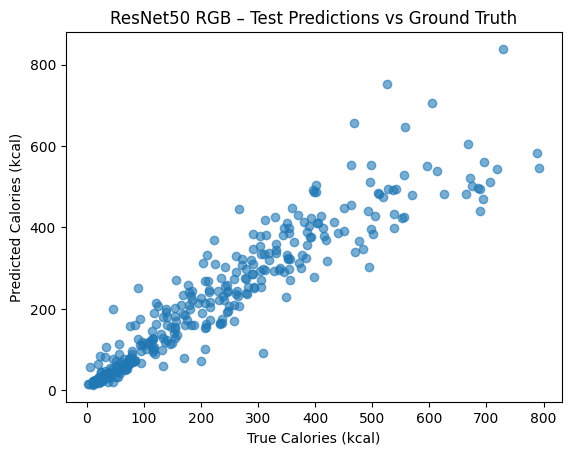

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("True Calories (kcal)")
plt.ylabel("Predicted Calories (kcal)")
plt.title("ResNet50 RGB – Test Predictions vs Ground Truth")
plt.show()

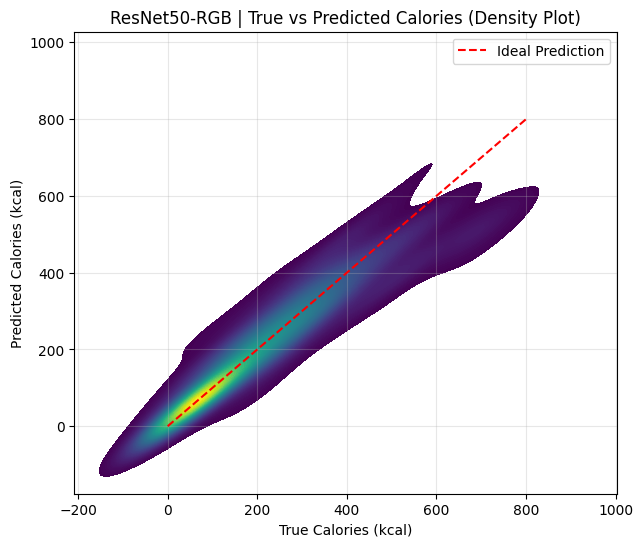

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7,6))
sns.kdeplot(x=y_true, y=y_pred, fill=True, cmap="viridis", thresh=0.05, levels=100)
plt.plot([0, 800], [0, 800], 'r--', label='Ideal Prediction')
plt.xlabel("True Calories (kcal)")
plt.ylabel("Predicted Calories (kcal)")
plt.title("ResNet50-RGB | True vs Predicted Calories (Density Plot)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

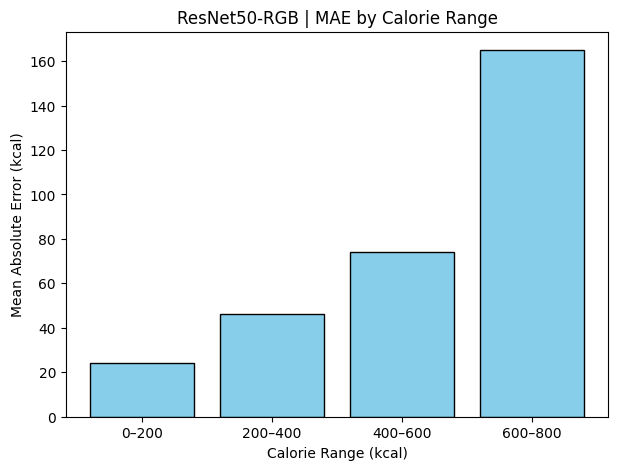

In [ ]:
bins = [0, 200, 400, 600, 800]
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
bin_indices = np.digitize(y_true, bins) - 1

mae_per_bin = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        mae_per_bin.append(np.mean(np.abs(y_true[mask] - y_pred[mask])))
    else:
        mae_per_bin.append(np.nan)

plt.figure(figsize=(7,5))
plt.bar(bin_labels, mae_per_bin, color='skyblue', edgecolor='black')
plt.xlabel("Calorie Range (kcal)")
plt.ylabel("Mean Absolute Error (kcal)")
plt.title("ResNet50-RGB | MAE by Calorie Range")
plt.show()

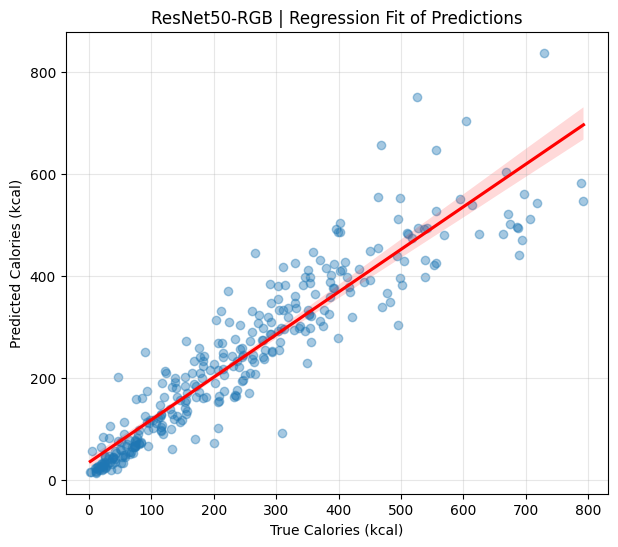

In [ ]:
import statsmodels.api as sm

plt.figure(figsize=(7,6))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("True Calories (kcal)")
plt.ylabel("Predicted Calories (kcal)")
plt.title("ResNet50-RGB | Regression Fit of Predictions")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import r2_score
# =====================================================
# 📊 NUMERIC SUMMARY
# =====================================================
overall_mae = np.mean(np.abs(y_true - y_pred))
overall_rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
overall_mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-3))) * 100
r2 = r2_score(y_true, y_pred)

print("\n Final Evaluation Summary:")
print(f"Overall Mean Absolute Error (MAE): {overall_mae:.2f} kcal")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.2f} kcal")
print(f"Overall Mean Absolute Percentage Error (MAPE): {overall_mape:.2f}%")
print(f"R² Correlation (Goodness of Fit): {r2:.3f}")

print("\n MAE by Calorie Range:")
for label, mae in zip(bin_labels, mae_per_bin):
    print(f"  {label} kcal: {mae:.2f} kcal")


 Final Evaluation Summary:
Overall Mean Absolute Error (MAE): 45.82 kcal
Overall Root Mean Squared Error (RMSE): 67.70 kcal
Overall Mean Absolute Percentage Error (MAPE): 31.38%
R² Correlation (Goodness of Fit): 0.863

 MAE by Calorie Range:
  0–200 kcal: 23.98 kcal
  200–400 kcal: 46.44 kcal
  400–600 kcal: 74.05 kcal
  600–800 kcal: 165.00 kcal


In [ ]:
import os

checkpoint_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb.pt"
if os.path.exists(checkpoint_path):
    print(f"The file {checkpoint_path} exists.")
else:
    print(f"The file {checkpoint_path} does NOT exist.")

The file /content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb.pt exists.


In [ ]:

# ============================================
# Model Definition
# ============================================
class ResNetSnapCal(nn.Module):
    def __init__(self):
        super(ResNetSnapCal, self).__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb):
        rgb_feat = self.pool(self.backbone(x_rgb)).flatten(1)
        return self.fc(rgb_feat)

In [ ]:
class NutritionDatasetRGBHeatDepth(Dataset):
    def __init__(self, labels_df, image_dir, transform_rgb=None, transform_mono=None):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform_rgb = transform_rgb
        self.transform_mono = transform_mono
        self.ids = labels_df["original_dish_id"].tolist()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        dish_id = self.ids[idx]

        # --- Load images ---
        rgb_img = safe_open(self.image_dir, dish_id, "rgb", "RGB")
        heat_img = safe_open(self.image_dir, dish_id, "heat", "L")
        depth_img = safe_open(self.image_dir, dish_id, "depth", "L")

        # --- Apply transforms ---
        if self.transform_rgb:
            rgb_img = self.transform_rgb(rgb_img)

        if self.transform_mono:
            heat_img = self.transform_mono(heat_img)
            depth_img = self.transform_mono(depth_img)

        # --- Label ---
        cal = torch.tensor(self.labels_df.loc[self.labels_df["original_dish_id"] == dish_id, "calories"].values[0], dtype=torch.float)

        return rgb_img, heat_img, depth_img, cal

In [ ]:
class NutritionDatasetRGB(Dataset):
    def __init__(self, labels_df, image_dir, transform_rgb):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform_rgb = transform_rgb

        self.ids = labels_df["original_dish_id"].tolist()
        self.calories = labels_df["calories"].tolist()

    def __getitem__(self, idx):
        dish_id = self.ids[idx]

        rgb_path = os.path.join(self.image_dir, f"{dish_id}_rgb.png")
        rgb_img = Image.open(rgb_path).convert("RGB")

        rgb = self.transform_rgb(rgb_img)
        cal = torch.tensor(self.calories[idx], dtype=torch.float32)

        return rgb, cal

    def __len__(self):
        return len(self.ids)

In [ ]:
class NutritionDatasetRGBGray(Dataset):
    def __init__(self, labels_df, image_dir, transform_rgb, transform_gray):
        self.labels_df = labels_df
        self.image_dir = image_dir
        self.transform_rgb = transform_rgb
        self.transform_gray = transform_gray

        self.ids = labels_df["original_dish_id"].tolist()
        self.calories = labels_df["calories"].tolist()

    def __getitem__(self, idx):
        dish_id = self.ids[idx]

        rgb_path = os.path.join(self.image_dir, f"{dish_id}_rgb.png")
        gray_path = os.path.join(self.image_dir, f"{dish_id}_gray.png")

        rgb_img = Image.open(rgb_path).convert("RGB")
        gray_img = Image.open(gray_path).convert("L")

        rgb = self.transform_rgb(rgb_img)
        gray = self.transform_gray(gray_img)
        cal = torch.tensor(self.calories[idx], dtype=torch.float32)

        return rgb, gray, cal

    def __len__(self):
        return len(self.ids)

In [ ]:
import pandas as pd
import os

csv_file = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/labels.csv"
img_folder = "/content/drive/MyDrive/kevin/nutrition5k_cleaned/images"

labels_df = pd.read_csv(csv_file)

# Remove corrupted ID
labels_df = labels_df[labels_df["original_dish_id"] != 1564159636]

# Keep only valid calorie range (0–800)
labels_df = labels_df[(labels_df["calories"] > 0) & (labels_df["calories"] <= 800)]

# Clean dish IDs
labels_df["original_dish_id"] = (
    labels_df["original_dish_id"]
    .astype(str)
    .str.replace(".0", "", regex=False)
    .str.strip()
)

# Check which IDs have both RGB & Gray images
rgb_files = {f.split("_")[0] for f in os.listdir(img_folder) if "_rgb.png" in f}
gray_files = {f.split("_")[0] for f in os.listdir(img_folder) if "_gray.png" in f}
valid_ids = sorted(list(rgb_files & gray_files))

labels_df = labels_df[labels_df["original_dish_id"].isin(valid_ids)].reset_index(drop=True)
print(f"✅ Valid samples after filtering: {len(labels_df)}")

✅ Valid samples after filtering: 3194


In [ ]:
import pandas as pd

# --- Build a simplified results table ---
clean_results = []

for item in comparison_results:
    clean_entry = {
        "Model": item.get("Model", "Unknown"),
        "MAE": round(item.get("MAE", 0), 2),
        "RMSE": round(item.get("RMSE", 0), 2),
        "MAPE%": round(item.get("MAPE", 0), 2)
    }

    # Add up to 3 sample predictions if available
    preds = item.get("SamplePredictions", [])
    if isinstance(preds, list) and len(preds) > 0:
        clean_entry["Example Preds"] = preds[:3]   # only first 3
    else:
        clean_entry["Example Preds"] = "N/A"

    clean_results.append(clean_entry)

df_clean = pd.DataFrame(clean_results)

# Sort by MAE (best model first)
df_clean = df_clean.sort_values(by="MAE").reset_index(drop=True)

print("📊 Condensed Model Comparison Table:\n")
display(df_clean)

print("\n📄 Copy-paste friendly Markdown:\n")
print(df_clean.to_markdown(index=False))

📊 Condensed Model Comparison Table:



,Model,MAE,RMSE,MAPE%,Example Preds
0,ResNet50-RGB,41.279999,63.189999,33.320000,N/A
1,EfficientNetB0-RGB,60.389999,85.680000,59.669998,N/A
2,DenseNet121-RGB,237.020004,298.309998,99.809998,N/A
3,CustomCNN-Hybrid_RGB AND GRAY ONLY,237.080002,298.390015,99.849998,N/A
4,CustomCNN-Hybrid,237.130005,298.429993,99.930000,N/A



📄 Copy-paste friendly Markdown:

| Model                              |    MAE |   RMSE |   MAPE% | Example Preds   |
|:-----------------------------------|-------:|-------:|--------:|:----------------|
| ResNet50-RGB                       |  41.28 |  63.19 |   33.32 | N/A             |
| EfficientNetB0-RGB                 |  60.39 |  85.68 |   59.67 | N/A             |
| DenseNet121-RGB                    | 237.02 | 298.31 |   99.81 | N/A             |
| CustomCNN-Hybrid_RGB AND GRAY ONLY | 237.08 | 298.39 |   99.85 | N/A             |
| CustomCNN-Hybrid                   | 237.13 | 298.43 |   99.93 | N/A             |


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labels_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 2306 | Val: 408 | Test: 480


In [ ]:
test_dataset_rgb_heat_depth = NutritionDatasetRGBHeatDepth(
    labels_df=test_df,
    image_dir=img_folder,
    transform_rgb=transform_rgb,
    transform_mono=transform_mono
)

test_loader_rgb_heat_depth = DataLoader(
    test_dataset_rgb_heat_depth,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
import torchvision.transforms as transforms

transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [ ]:
transform_mono = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # 1-channel normalization
])

In [ ]:
test_dataset_rgb = NutritionDatasetRGB(
    labels_df=test_df,
    image_dir=img_folder,
    transform_rgb=transform_rgb
)

test_loader_rgb = DataLoader(test_dataset_rgb, batch_size=16, shuffle=False)

In [ ]:
test_dataset_rgb_gray = NutritionDatasetRGBGray(
    labels_df=test_df,
    image_dir=img_folder,
    transform_rgb=transform_rgb,
    transform_gray=transform_mono
)

test_loader_rgb_gray = DataLoader(test_dataset_rgb_gray, batch_size=16, shuffle=False)

In [ ]:
test_dataset_rgb = NutritionDatasetRGB(
    test_df, img_folder, transform_rgb
)
test_loader_rgb = DataLoader(test_dataset_rgb, batch_size=8, shuffle=False)

test_dataset_rgb_gray = NutritionDatasetRGBGray(
    test_df, img_folder, transform_rgb, transform_mono
)
test_loader_rgb_gray = DataLoader(test_dataset_rgb_gray, batch_size=8, shuffle=False)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import r2_score

def evaluate_any_model(model, test_loader, device, mode="rgb"):
    model.eval()
    mae_list, mse_list = [], []
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:

            if mode == "rgb":
                rgb, cal = batch
                rgb, cal = rgb.to(device), cal.to(device)
                preds = model(rgb)

            elif mode == "rgb_gray":
                rgb, gray, cal = batch
                rgb, gray, cal = rgb.to(device), gray.to(device), cal.to(device)
                preds = model(rgb, gray)

            elif mode == "rgb_heat_depth":
                rgb, heat, depth, cal = batch
                rgb = rgb.to(device)
                heat = heat.to(device)
                depth = depth.to(device)
                cal = cal.to(device)
                preds = model(rgb, heat, depth)

            else:
                raise ValueError("Unknown model mode!")

            preds = preds.squeeze()

            y_true.extend(cal.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            mae_list.append(torch.abs(preds - cal).mean().item())
            mse_list.append(((preds - cal) ** 2).mean().item())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_pred - y_true))
    mse = np.mean((y_pred - y_true) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-5, None))) * 100
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "MSE": mse,
        "true": y_true,
        "pred": y_pred,
    }

In [ ]:
comparison_list = [
    {
        "name": "ResNet50-RGB",
        "path": "/content/drive/MyDrive/nutrition_model_checkpoints/best_resnet50_rgb_retrained.pt",
        "constructor": ResNetSnapCal, # your class
        "mode": "rgb"
    },
    {
        "name": "EfficientNetB0-RGB",
        "path": "/content/drive/MyDrive/nutrition_model_checkpoints/best_efficientnetb0.pt",
        "constructor": EfficientNetSnapCal,
        "mode": "rgb_gray"
    },
    {
        "name": "DenseNet121-RGB",
        "path": "/content/drive/MyDrive/nutrition_model_checkpoints/best_densenet121_rgb.pt",
        "constructor": DenseNetSnapCal,
        "mode": "rgb"
    },
    {
        "name": "SnapCalCNN + Resnet (RGB/GRAY/DEPTH)",
        "path": "/content/drive/MyDrive/nutrition_model_checkpoints/best_hybrid_model.pt",
        "constructor": MultiInputSnapCalCNN,
        "mode": "rgb_gray"
    },
    {
        "name": "SnapCalCNN RGB and GRAY",
        "path": "/content/drive/MyDrive/nutrition_model_checkpoints/best_hybrid_rgb_gray_model.pt",
        "constructor": MultiInputSnapCalCNN,
        "mode": "rgb_gray"
    }
]

In [ ]:
import pandas as pd


comparison_results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for item in comparison_list:
    print(f"Evaluating {item['name']}...")

    model = item["constructor"]().to(device)
    state = torch.load(item["path"], map_location=device, weights_only=False)
    model.load_state_dict(state["model_state_dict"], strict=False)
    model.eval()

    # Select correct dataloader
    if item["mode"] == "rgb":
        loader = test_loader_rgb

    elif item["mode"] == "rgb_gray":
        loader = test_loader_rgb_gray

    elif item["mode"] == "rgb_heat_depth":
        loader = test_loader_rgb_heat_depth  # if exists

    metrics = evaluate_any_model(model, loader, device, mode=item["mode"])
    metrics["Model"] = item["name"]
    comparison_results.append(metrics)

Evaluating ResNet50-RGB...
Evaluating EfficientNetB0-RGB...
Evaluating DenseNet121-RGB...
Evaluating CustomCNN-Hybrid...
Evaluating CustomCNN-Hybrid_RGB AND GRAY ONLY...


In [ ]:
import pandas as pd

df_results = pd.DataFrame(comparison_results)

# --- Identify MAE column (supports "MAE", "MAE (kcal)", etc.)
mae_column = None
for col in df_results.columns:
    if "mae" in col.lower():   # flexible auto-detect
        mae_column = col
        break

if mae_column is None:
    raise ValueError("❌ No MAE column found in results. Check comparison_results structure.")

# --- Sort by detected MAE column
df_results = df_results.sort_values(by=mae_column).reset_index(drop=True)

print("📊 Model Comparison Table (sorted by MAE):")
display(df_results)

print("\n📄 Markdown Table (copy for your report):\n")
print(df_results.to_markdown(index=False))

📊 Model Comparison Table (sorted by MAE):


,MAE,RMSE,MAPE,R2,MSE,true,pred,Model
0,41.277599,63.191227,33.320446,0.878368,3993.131348,"[278.307, 30.6, 280.8, 13.64, 409.57, 146.64, ...","[297.46188, 33.140472, 236.92091, 20.824995, 4...",ResNet50-RGB
1,60.390995,85.676285,59.673756,0.776408,7340.425293,"[278.307, 30.6, 280.8, 13.64, 409.57, 146.64, ...","[299.34396, 105.88435, 216.62956, 25.683826, 4...",EfficientNetB0-RGB
2,237.020325,298.313629,99.805641,-1.710704,88991.023438,"[278.307, 30.6, 280.8, 13.64, 409.57, 146.64, ...","[0.113473, 0.11237456, 0.1574108, 0.11219857, ...",DenseNet121-RGB
3,237.079941,298.389618,99.847832,-1.712085,89036.359375,"[278.307, 30.6, 280.8, 13.64, 409.57, 146.64, ...","[0.092718735, 0.09260162, 0.093155906, 0.09242...",CustomCNN-Hybrid_RGB AND GRAY ONLY
4,237.127411,298.427216,99.925728,-1.712769,89058.804688,"[278.307, 30.6, 280.8, 13.64, 409.57, 146.64, ...","[0.04622366, 0.045133177, 0.04614624, 0.044380...",CustomCNN-Hybrid



📄 Markdown Table (copy for your report):

|      MAE |     RMSE |    MAPE |        R2 |      MSE | true                                                                | pred                                                                | Model                              |
|---------:|---------:|--------:|----------:|---------:|:--------------------------------------------------------------------|:--------------------------------------------------------------------|:-----------------------------------|
|  41.2776 |  63.1912 | 33.3204 |  0.878368 |  3993.13 | [278.307     30.6      280.8       13.64     409.57     146.64      | [297.46188   33.140472 236.92091   20.824995 447.2144   156.08197   | ResNet50-RGB                       |
|          |          |         |           |          |  141.       385.44196  308.89444  555.93274  462.93378  115.54401   |  161.48871  358.03522  228.84784  425.72012  454.437    128.98831   |                                    |
|          |         

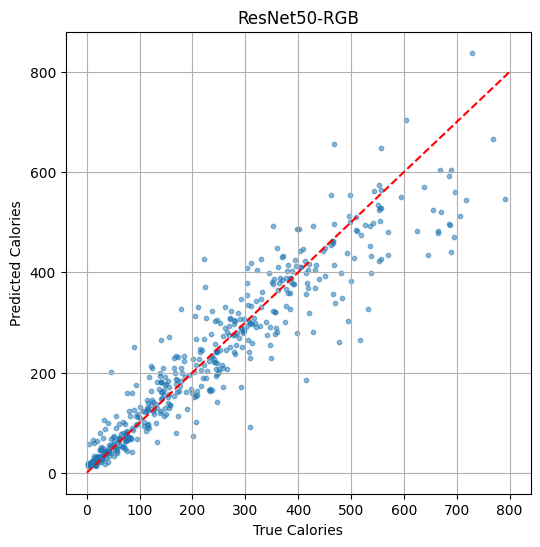

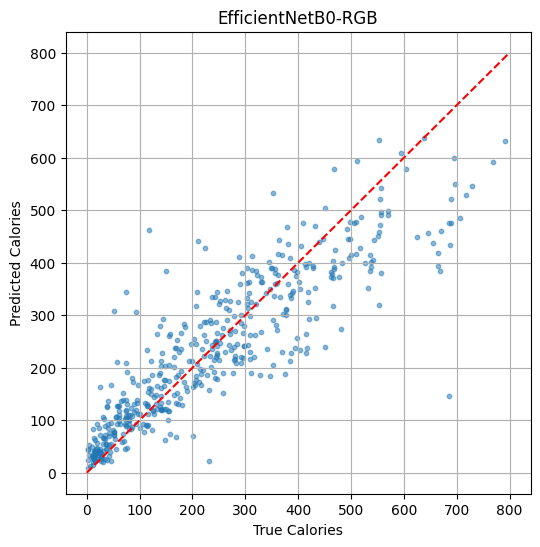

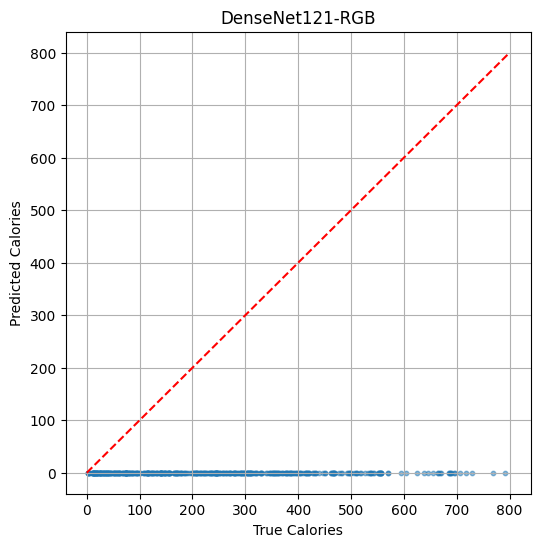

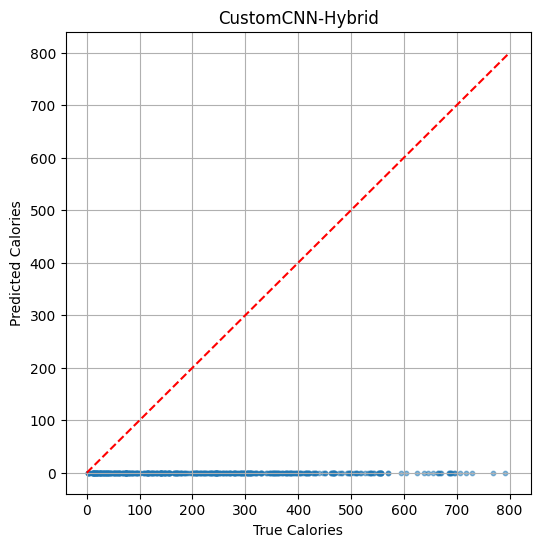

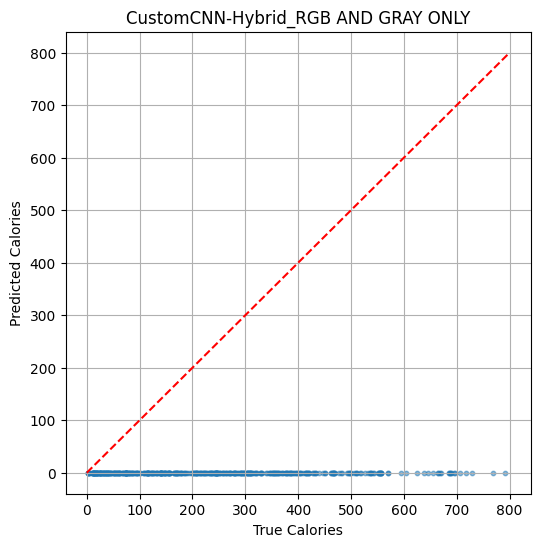

In [ ]:
import matplotlib.pyplot as plt

for item in comparison_results:
    plt.figure(figsize=(6,6))
    plt.scatter(item["true"], item["pred"], s=10, alpha=0.5)
    plt.plot([0,800], [0,800], 'r--')

    plt.title(item["Model"])
    plt.xlabel("True Calories")
    plt.ylabel("Predicted Calories")
    plt.grid(True)
    plt.show()

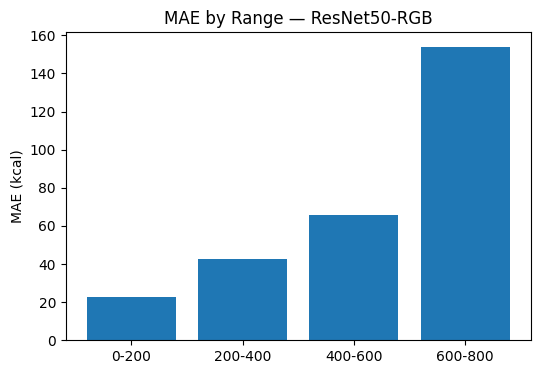

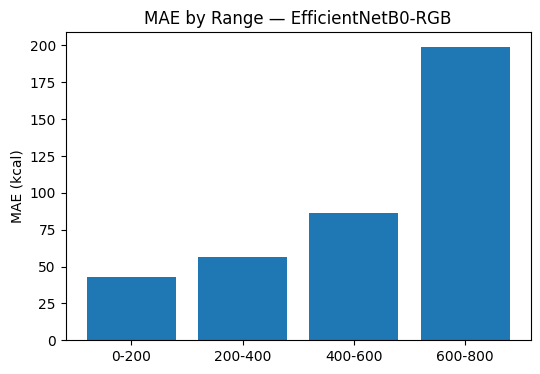

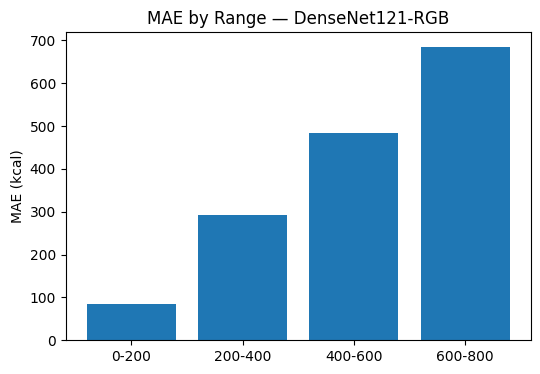

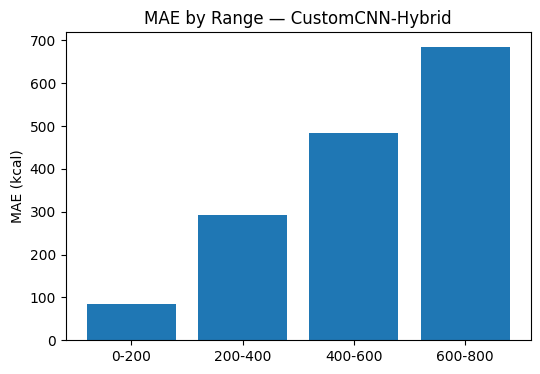

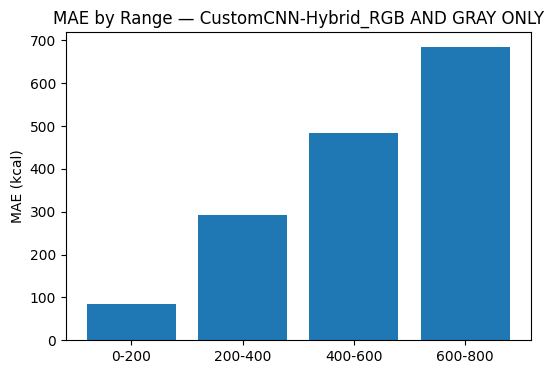

In [ ]:
ranges = [(0,200),(200,400),(400,600),(600,800)]

for item in comparison_results:
    y, p = item["true"], item["pred"]
    errors = []
    for lo,hi in ranges:
        mask = (y>=lo)&(y<hi)
        if mask.sum() > 0:
            errors.append(np.mean(np.abs(y[mask]-p[mask])))
        else:
            errors.append(None)

    plt.figure(figsize=(6,4))
    plt.bar(["0-200","200-400","400-600","600-800"], errors)
    plt.title(f"MAE by Range — {item['Model']}")
    plt.ylabel("MAE (kcal)")
    plt.show()

In [ ]:
# --- Model Definition ---
class EfficientNetSnapCal(nn.Module):
    def __init__(self):
        super(EfficientNetSnapCal, self).__init__()
        base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.rgb_backbone = nn.Sequential(*list(base.features.children()))
        self.gray_backbone = nn.Sequential(*list(base.features.children()))
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_rgb, x_gray):
        # EfficientNet expects 3-channel input; duplicate grayscale to match
        if x_gray.shape[1] == 1:
            x_gray = x_gray.repeat(1, 3, 1, 1)

        rgb_feat = self.pool(self.rgb_backbone(x_rgb)).flatten(1)
        gray_feat = self.pool(self.gray_backbone(x_gray)).flatten(1)
        combined = torch.cat((rgb_feat, gray_feat), dim=1)
        return self.fc(combined)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
eff = EfficientNetSnapCal().to(device)

# Load checkpoint
chk = torch.load("/content/drive/MyDrive/nutrition_model_checkpoints/best_efficientnetb0.pt",
                 map_location=device)
eff.load_state_dict(chk["model_state_dict"], strict=False)

print("✅ EfficientNet loaded. Running evaluation...")
evaluate_model(eff, test_loader, device)

✅ EfficientNet loaded. Running evaluation...


TypeError: EfficientNetSnapCal.forward() missing 1 required positional argument: 'x_gray'

In [ ]:
import torch.nn as nn
import torchvision.models as models

class DenseNetSnapCal(nn.Module):
    def __init__(self):
        super().__init__()

        # This matches your TRAINING architecture
        self.backbone = models.densenet121(weights=None)  # no pretrained, because your checkpoint has the weights
        self.features = self.backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Your regression head shape based on DenseNet-121 output (1024)
        self.regressor = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

In [ ]:
dense_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_densenet121_rgb.pt"

dense = DenseNetSnapCal().to(device)
dense.load_state_dict(torch.load(dense_path, map_location=device)["model_state_dict"], strict = False)

print("✅ Loaded DenseNet checkpoint")

✅ Loaded DenseNet checkpoint


In [ ]:
y_true_dense, y_pred_dense = evaluate_model(dense, test_loader, device, "DenseNet121-RGB")


Evaluating DenseNet121-RGB: 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


📊 FINAL EVALUATION RESULTS: DenseNet121-RGB
MAE:  241.44 kcal
RMSE: 303.06 kcal
MAPE: 99.87%
R²:   -1.7359


In [ ]:
def collect_predictions(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for rgb, cal in test_loader:
            rgb = rgb.to(device)
            cal = cal.to(device)

            preds = model(rgb).squeeze()

            y_true.extend(cal.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())

    return np.array(y_true), np.array(y_pred)


# --- Run prediction collection ---
y_true_dense, y_pred_dense = collect_predictions(dense, test_loader, device)
print("Done collecting predictions!")

Done collecting predictions!


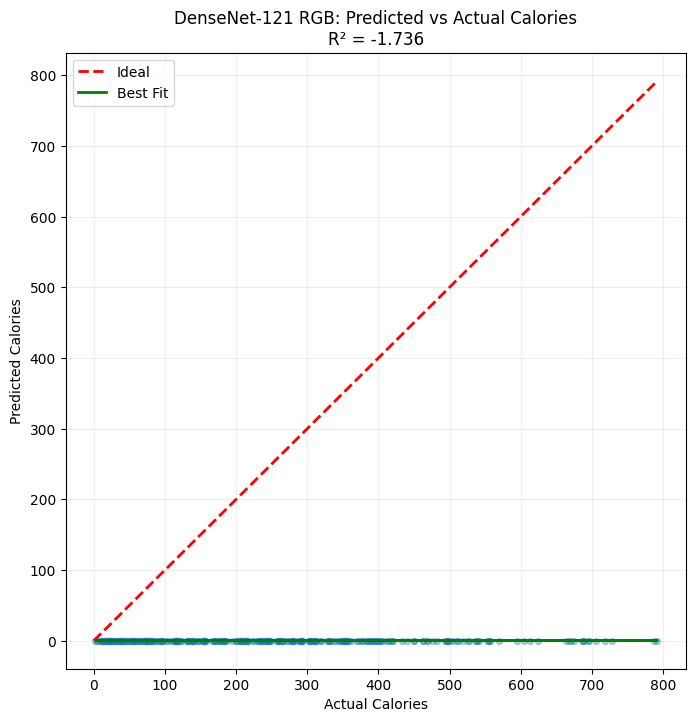

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def plot_scatter(y_true, y_pred, model_name="DenseNet"):
    plt.figure(figsize=(8, 8))

    # Scatter
    plt.scatter(y_true, y_pred, alpha=0.35, s=18)

    # Identity line
    lims = [0, max(max(y_true), max(y_pred))]
    plt.plot(lims, lims, 'r--', linewidth=2, label="Ideal")

    # Regression line
    m, b = np.polyfit(y_true, y_pred, 1)
    plt.plot(y_true, m * y_true + b, color='green', linewidth=2, label="Best Fit")

    # Labels
    r2 = r2_score(y_true, y_pred)
    plt.title(f"{model_name}: Predicted vs Actual Calories\nR² = {r2:.3f}")
    plt.xlabel("Actual Calories")
    plt.ylabel("Predicted Calories")
    plt.legend()

    plt.grid(alpha=0.2)
    plt.show()


plot_scatter(y_true_dense, y_pred_dense, model_name="DenseNet-121 RGB")

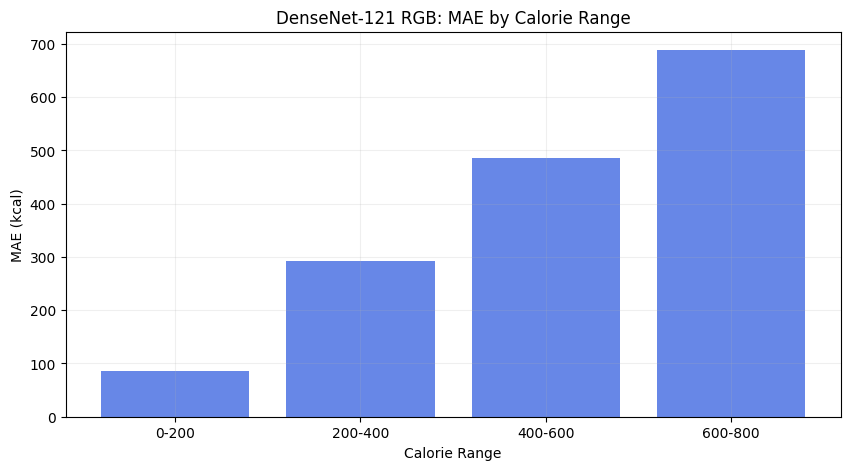

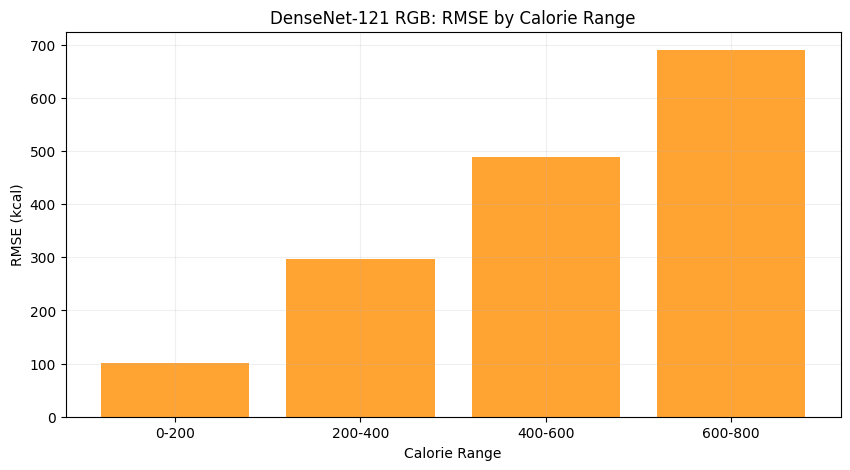

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def error_by_range(y_true, y_pred, bins=[0,200,400,600,800], model_name="DenseNet"):
    ranges = []
    mae_list = []
    rmse_list = []

    for i in range(len(bins)-1):
        low, high = bins[i], bins[i+1]

        mask = (y_true >= low) & (y_true < high)
        y_t = y_true[mask]
        y_p = y_pred[mask]

        if len(y_t) == 0:
            mae, rmse = None, None
        else:
            mae = np.mean(np.abs(y_t - y_p))
            rmse = np.sqrt(np.mean((y_t - y_p) ** 2))

        ranges.append(f"{low}-{high}")
        mae_list.append(mae)
        rmse_list.append(rmse)

    # Plot MAE
    plt.figure(figsize=(10,5))
    plt.bar(ranges, mae_list, color='royalblue', alpha=0.8)
    plt.title(f"{model_name}: MAE by Calorie Range")
    plt.ylabel("MAE (kcal)")
    plt.xlabel("Calorie Range")
    plt.grid(alpha=0.2)
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(10,5))
    plt.bar(ranges, rmse_list, color='darkorange', alpha=0.8)
    plt.title(f"{model_name}: RMSE by Calorie Range")
    plt.ylabel("RMSE (kcal)")
    plt.xlabel("Calorie Range")
    plt.grid(alpha=0.2)
    plt.show()

    return ranges, mae_list, rmse_list


ranges, mae_list, rmse_list = error_by_range(
    y_true_dense,
    y_pred_dense,
    model_name="DenseNet-121 RGB"
)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EfficientNetRGBOnly(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.backbone = base.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feat = self.pool(self.backbone(x)).flatten(1)
        return self.fc(feat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eff = EfficientNetSnapCal().to(device)

eff_path = "/content/drive/MyDrive/nutrition_model_checkpoints/best_efficientnetb0.pt"

checkpoint = torch.load(eff_path, map_location=device)
eff.load_state_dict(checkpoint["model_state_dict"], strict=False)

print("EfficientNet-B0 dual-input checkpoint loaded successfully.")

✅ EfficientNet-B0 dual-input checkpoint loaded successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def evaluate_efficientnet_dual(model, test_loader, device):

    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for rgb, gray, cal in test_loader:
            rgb = rgb.to(device)
            gray = gray.to(device)
            cal = cal.to(device)

            preds = model(rgb, gray).squeeze()

            y_true.extend(cal.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # --- Metrics ---
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2 = r2_score(y_true, y_pred)

    # --- Range Slice ---
    ranges = {
        "0–200": (0, 200),
        "200–400": (200, 400),
        "400–600": (400, 600),
        "600–800": (600, 800),
    }

    range_mae = {}
    for label, (lo, hi) in ranges.items():
        mask = (y_true >= lo) & (y_true < hi)
        if mask.sum() > 0:
            range_mae[label] = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        else:
            range_mae[label] = None

    # --- Print Results ---
    print("\n=== EfficientNet-B0 Final Evaluation ===")
    print(f"MAE:  {mae:.2f} kcal")
    print(f"RMSE: {rmse:.2f} kcal")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")

    print("\nMAE by Calorie Range:")
    for r, v in range_mae.items():
        print(f"  {r}: {v:.2f} kcal")

    # --- Plot 1: Scatter (Pred vs True) ---
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, 800], [0, 800], 'r--')
    plt.xlabel("True Calories")
    plt.ylabel("Predicted Calories")
    plt.title("EfficientNet-B0 — Predicted vs True")
    plt.grid()
    plt.show()

    # --- Plot 2: Histogram of Errors ---
    errors = y_pred - y_true
    plt.figure(figsize=(7, 5))
    plt.hist(errors, bins=40, edgecolor='black')
    plt.title("Prediction Error Distribution")
    plt.xlabel("Error (Pred - True)")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

    return mae, rmse, mape, r2, range_mae

In [ ]:
batch = next(iter(test_loader))
print(len(batch))


2


In [8]:
import streamlit as st
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import io
import pickle
import numpy as np
import torchvision.models as models

st.set_page_config(page_title="SnapCal", layout="centered", initial_sidebar_state="auto")
with open('app.py', 'w') as f:
  f.write('''
import streamlit as st
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import io
import pickle
import numpy as np
import os
from torchvision.transforms import Grayscale
import cv2 # Keep cv2 import for image processing
import torchvision.models as models # Import torchvision models

# ---- Stylish Hero Section with Background ----

background_img_url = "https://images.pexels.com/photos/70497/pexels-photo-70497.jpeg?auto=compress&fit=crop&w=1350&q=80"
icon_url = "https://cdn-icons-png.flaticon.com/512/1046/1046857.png" # food plate icon

st.set_page_config(page_title="SnapCal", layout="centered", initial_sidebar_state="auto")

st.markdown(
     f\"\"\"
    <style>
    body {{
        background: linear-gradient(120deg, #FCFF6C 0%, #f3f4f9 100%);
        font-family: 'Segoe UI', 'Roboto', sans-serif;
    }}
    .stApp {{
        background-image: url('{background_img_url}');
        background-size: cover;
        background-attachment: fixed;
    }}
    .hero-card {{
        background: rgba(255,255,255,0.80);
        border-radius: 32px;
        padding: 2.5rem 2rem 2.5rem 2rem;
        margin: 2rem auto 2rem auto;
        box-shadow: 0 7px 32px 4px rgba(16,32,45,0.10);
        max-width: 600px;
        position: relative;
        backdrop-filter: blur(2.5px);
    }}
    .snapcal-title {{
        font-family: 'Montserrat', 'Segoe UI', Arial, sans-serif;
        font-weight: 900;
        font-size: 3rem;
        color: #1e3a8a;
        margin-bottom: .25rem;
        letter-spacing: 2.5px;
        text-shadow: 0 2px 16px #fefbde, 0 1px 4px #ffe5b1;
        text-align: center;
    }}
    .app-description {{
        color: #3d4f77;
        font-size: 1.13rem;
        text-align: center;
        margin-bottom: .5rem;
        line-height: 1.7;
    }}
    .snapcal-divider {{
        margin: 2.5rem 0 2rem 0; height:2px; background:#ffdc51; border-radius:20px;
        border:none;
    }}
    .title-icon {{
        width:55px; display:block; margin: 0 auto 6px auto; filter: drop-shadow(0 2px 6px #fff9c25e);
    }}
    .stButton>button {{
        background: linear-gradient(90deg,#ffdc51,#f8ffae 90%);
        color: #1e3a8a;
        font-weight: 700;
        border-radius: 10px;
        border: none;
        font-size: 1.17rem;
        margin-top: .5rem;
        padding: 12px 28px;
        transition: background .2s, color .2s;
        box-shadow:0 2px 8px #efefdb42;
    }}
    .stButton>button:hover {{
        background: #ffe03c;
        color: #007bff;
    }}
    .stFileUploader > div[data-testid="stFileUploaderDropzone"] {{
        border: 2px dashed #1e3a8a;
        border-radius: 12px;
        background: #fffbe7bb;
        color: #1e3a8a;
    }}
    .stFileUploader label {{
        font-size: 1.04rem;
        color: #18306e;
        letter-spacing: 0.5px;
    }}
    .stAlert {{
        border-radius: 10px;
    }}
    </style>
  \"\"\",
    unsafe_allow_html=True
)

st.markdown(
    f\"\"\"
    <div class="hero-card">
        <img src="{icon_url}" class="title-icon" alt="SnapCal Logo">
        <div class="snapcal-title">SnapCal</div>
        <div class="app-description">
            AI-powered calorie estimation from a single photo.<br>
            Upload a meal image, and SnapCal will instantly analyze and predict its calories.<br>
            <span style='color:#FFD700;font-weight:600;'>Eat smart, snap fast, stay healthy.</span>
        </div>
    </div>
    \"\"\",
    unsafe_allow_html=True
)

# ---- Main App Logic (Buttons, Upload, Results) ----

st.write("")
st.markdown('<hr class="snapcal-divider"/>', unsafe_allow_html=True)

if 'show_camera' not in st.session_state:
    st.session_state.show_camera = False

if st.button("Take a Photo"):
    st.session_state.show_camera = True

uploaded_file = st.file_uploader(
    "Upload your meal photo (.png, .jpg, .jpeg)...",
    type=["png", "jpg", "jpeg"],
    key="main-uploader"
)

camera_image = st.camera_input("Or capture with webcam") if st.session_state.show_camera else None

image = None
if uploaded_file is not None:
    from PIL import Image
    image = Image.open(uploaded_file).convert("RGB")
elif camera_image is not None:
    from PIL import Image
    image = Image.open(camera_image).convert("RGB")

if image is not None:
    st.image(image, caption="Your submitted meal", use_column_width=True)
    if st.button("Estimate Calories"):
        # --- Model inference placeholder ---
        # Replace this with your PyTorch/TorchVision prediction code!
        import random
        est_kcal = random.uniform(230, 600)
        st.success(f"Estimated Calories: {est_kcal:.1f} kcal")
        st.info("Nutritional estimate based on AI analysis. For best results, use clear and well-lit meal images.")

else:
    st.write(
        '<div style="text-align:center;color:#888;font-size:1.1rem;">'
        'No image uploaded yet.<br>Drag and drop, browse, or use the camera above.'
        '</div>',
        unsafe_allow_html=True
    )

st.write("")
st.markdown('<hr class="snapcal-divider"/>', unsafe_allow_html=True)

st.caption("© 2025 SnapCal – Creative Technologies Capstone")
''')

2025-11-16 03:09:46.342 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
pip install streamlit

In [9]:
#Initialize Front end with port and link

# Stop any potentially lingering streamlit processes more aggressively
!kill -9 $(lsof -i :8501 -t) >/dev/null 2>&1 || true
!kill -9 $(lsof -i :8502 -t) >/dev/null 2>&1 || true
!pkill -f streamlit
print("Attempted to kill all streamlit processes.")

# Add a small delay to ensure processes are stopped
import time
time.sleep(7) # Increased sleep time

# Install necessary libraries before running the app
!pip install pyngrok streamlit opencv-python

# Add another delay after installation
time.sleep(10)


# Restart the streamlit app on a new port
!streamlit run app.py --server.port 8503 > streamlit.log 2>&1 &

from pyngrok import ngrok
import os
from google.colab import userdata
import time

# Get your authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
if NGROK_AUTH_TOKEN is None:
    print("NGROK_AUTH_TOKEN not found in Colab secrets. Please add it.")
else:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    print("Waiting for Streamlit app to start...")
    # Increased delay to give Streamlit more time to start and ngrok to connect
    time.sleep(15)

    try:
        # Kill existing ngrok tunnels before connecting
        ngrok.kill()
        print("Killed existing ngrok tunnels before starting a new one.")
        # Connect to the new port 8503
        public_url = ngrok.connect(8503)
        print(f"Streamlit app URL: {public_url}")
    except Exception as e:
        print(f"Error connecting ngrok: {e}")
        print("Please check if Streamlit is running and accessible on port 8503.")

Attempted to kill all streamlit processes.
Waiting for Streamlit app to start...
Killed existing ngrok tunnels before starting a new one.
Streamlit app URL: NgrokTunnel: "https://incommunicative-funnily-melda.ngrok-free.dev" -> "http://localhost:8503"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
